## Forecasting Code for Mutivariate Time Series Data


### Getting Started

In this notebook, we will create an AI and time serie driven forecasting engine based on a set of 5 AI models and 5 time series models and  employ several algorithms to perform feature engennering and selection on a multivaraite time series dataset. We are trying to find the best drivers of the HK flat price using various macro economics data.The dataset we are using is the 'HK macroeconomics data' from Kaggle. It is a daily dataset starting from 2nd January 2003 and goes on till 26th November 2019. The target variable is 'Private Domestic (Price Index)' and there 12 features which can help us forecast HK flat price. The dataset can be found [here](https://www.kaggle.com/stanley11291985/hk-macroeconomics-data?)


We will first do exploratory data analysis on the data and then move on to data cleaning where we do the following:

1. Check if any dates are missing and add the missing dates
2. Use linear interpolation to fill the nulls (we will also provide the code for forward and backward fill
3. Perform outlier detection
4. Perform outlier treatment
5. Check time series components, ACF and PACF plots of target variable

Once the data has been cleaned up, we will create the following additional features:

1. 3 lags for each feature
2. Daily change for each feature
3. A flag for holidays
5. Flag for S&P 500 index
4. Calculate First hand sales price and drop the sales amount variable

The next step is to perform featue selection using the following techniques:

1. Select the top n features based on feature importance from random forest
2. Select the top n features based on absolute correlation with target variable
3. Select the features identified by Lasso regression
4. Select features by recursively considering smaller and smaller sets of features
5. Select the top n features based on absolute value of beta coefficients of features

The final features are the ones selected in at least 3 out of 5 models.

After feature selection, we train a set of 10 models (and perform hyper parameter tuning wherever required):

1. SARIMA (Univariate Time Series)
2. Holt Winters (Univariate Time Series)
3. SARIMAX(Multi-variate Time Series)
4. VAR(Multi-variate Time Series)
5. VECM(Multi-variate Time Series)
6. LSTM (Univariate Time Series)
7. Random Forest (Multi-variate AI)
8. XG Boost (Multi-variate AI)
9. Linear Regression (Multi-variate AI)
10. SVR (Multi-variate AI)

We make predictions for the next year using all the models and then take their average as the final predictions.

#### Exploring the Data
In this section, we load necessary Python libraries and load the multivariate time series data. Note that the column 'Private Domestic (Price Index)' from this dataset will be our target label. All other columns are features. We perform EDA like visualising and understaind the mean, min, max etc of the fields.

In [71]:
# Import Necessary Libraries

#!pip install pyod

import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso, LassoCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
import statsmodels.api as sm
from scipy.stats.mstats import zscore
from pyod.models.abod import ABOD
from pyod.models.knn import KNN
import seaborn as sns
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
from pandas import Series
from matplotlib import pyplot

import pmdarima as pm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.stattools import adfuller
from  statsmodels.tsa.vector_ar.vecm import *


import itertools
import math
import random
import xgboost as xgb
import tensorflow
import keras
from keras.layers import Dropout
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR

#!pip install --trusted-host=pypi.org --trusted-host=files.pythonhosted.org --user pmdarima

In [72]:
# Input the dataset
df1 = pd.read_excel('Housing market data.xlsx',
              sheet_name='Upsampled')

df1.head(5)

,Date,Private Domestic (Price Index),First hand sales quantity,First hand sales amount,Total completions,Total stock,Total take up,Total vacancy,Unemployment rate (seasonally adjusted) (%),CPI,HIBOR (1-month),M3 (HK$ million),HSI - close,HSI - volume
0,2003-01-02,64.559769,1854.689208,5.846897e+09,33983.762413,1.092844e+06,19914.083323,74177.818318,7.301525,73.721486,1.44420,3.562189e+06,9365.519531,126907400.0
1,2003-01-03,64.506848,1892.762372,5.927523e+09,33932.818955,1.092244e+06,19900.006814,74155.621001,7.299043,73.717079,1.41741,3.562586e+06,9583.849609,291454400.0
2,2003-01-06,64.453848,1931.338866,5.998876e+09,33882.041253,1.091646e+06,19886.125236,74133.429251,7.296561,73.712684,1.40402,3.563044e+06,9665.959961,234912800.0
3,2003-01-07,64.400768,1970.418692,6.060958e+09,33831.429307,1.091050e+06,19872.438591,74111.243068,7.294081,73.708301,1.39063,3.563562e+06,9652.400391,267021800.0
4,2003-01-08,64.347610,2010.001848,6.113768e+09,33780.983117,1.090457e+06,19858.946877,74089.062450,7.291601,73.703930,1.39732,3.564141e+06,9688.209961,202439200.0


In [73]:
#Check number of rows and columns, type of each columns
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4233 entries, 0 to 4232
Data columns (total 14 columns):
 #   Column                                       Non-Null Count  Dtype         
---  ------                                       --------------  -----         
 0   Date                                         4233 non-null   datetime64[ns]
 1   Private Domestic (Price Index)               4233 non-null   float64       
 2   First hand sales quantity                    4233 non-null   float64       
 3   First hand sales amount                      4233 non-null   float64       
 4   Total completions                            4233 non-null   float64       
 5   Total stock                                  4233 non-null   float64       
 6   Total take up                                4233 non-null   float64       
 7   Total vacancy                                4233 non-null   float64       
 8   Unemployment rate (seasonally adjusted) (%)  4233 non-null   float64       
 9

In [74]:
# Understanding the numeric fields
df1.describe()

,Private Domestic (Price Index),First hand sales quantity,First hand sales amount,Total completions,Total stock,Total take up,Total vacancy,Unemployment rate (seasonally adjusted) (%),CPI,HIBOR (1-month),M3 (HK$ million),HSI - close,HSI - volume
count,4233.000000,4233.000000,4.233000e+03,4233.000000,4.233000e+03,4233.000000,4233.000000,4233.000000,4233.000000,4233.000000,4.233000e+03,4233.000000,4.233000e+03
mean,197.064993,1406.732017,1.145308e+10,15387.011646,1.106643e+06,14036.055785,52835.021903,4.202867,88.188533,1.180317,8.375635e+06,20781.490429,1.492191e+09
std,104.268475,758.310792,6.934301e+09,6413.960753,5.073772e+04,6483.743342,9013.878325,1.273481,12.713668,1.415258,3.553012e+06,5303.246267,9.137858e+08
min,58.400000,-2.690601,4.424446e+05,6792.576078,1.006630e+06,-4077.411618,41975.928483,2.800000,71.700000,0.040180,3.548561e+06,8409.009766,0.000000e+00
25%,96.834930,863.244685,6.124111e+09,9942.919441,1.073121e+06,9516.701115,45758.833205,3.134502,75.520451,0.212860,5.279677e+06,17048.419922,9.293672e+08
50%,181.300974,1292.923682,1.038705e+10,13810.857627,1.106639e+06,12693.239693,49973.213330,3.649037,86.187916,0.345000,7.660015e+06,21654.160156,1.495348e+09
75%,284.135754,1845.392958,1.568220e+10,19112.456257,1.142288e+06,16988.464263,62994.641229,5.077025,100.297864,1.747140,1.147862e+07,23919.949219,1.947201e+09
max,397.100022,4151.298770,3.834408e+10,33983.762413,1.214837e+06,31536.196716,74177.818318,8.500000,111.000000,5.703570,1.470108e+07,33154.121094,9.799120e+09


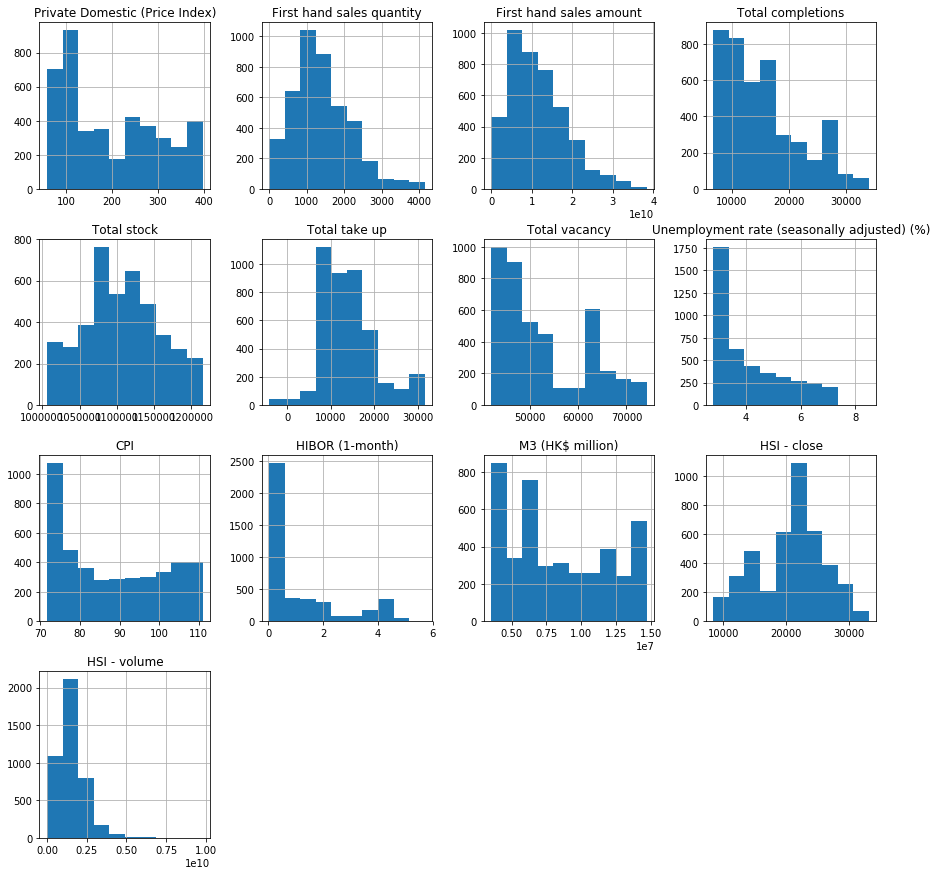

In [75]:
# Histogram of all numeric fields
df_hist = df1.drop(columns=['Date'],axis=1)
df_hist.hist(figsize=(15,15));

In [76]:
# Visaluise the target variable
plt.plot(df1['Date'], df1['Private Domestic (Price Index)'])


C:\Users\ibaruah001\AppData\Local\Annaconda\lib\site-packages\matplotlib\cbook\__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\ibaruah001\AppData\Local\Annaconda\lib\site-packages\matplotlib\axes\_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\ibaruah001\AppData\Local\Annaconda\lib\site-packages\matplotlib\axes\_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x0000024CD8FD0400> (for post_execute):


OverflowError: Python int too large to convert to C long

OverflowError: Python int too large to convert to C long

#### Cleaning the Data

In this section we do the following:

1. Check if any dates are missing and add the missing dates
2. Use linear interpolation to fill the nulls (we will also provide the code for forward and backward fill
3. Perform outlier detection
4. Perform outlier treatment


In [77]:
# Check if any dates are missing
daily_data = pd.DataFrame(pd.date_range(start=df1['Date'].min(),end=df1['Date'].max()))
daily_data.rename(columns={ daily_data.columns[0]: "Date" }, inplace = True)
daily_data.describe()

C:\Users\ibaruah001\AppData\Local\Annaconda\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  after removing the cwd from sys.path.


,Date
count,6173
unique,6173
top,2006-07-20 00:00:00
freq,1
first,2003-01-02 00:00:00
last,2019-11-26 00:00:00


There are 6173 records between "2003-01-02" and "2019-11-26" but the original data only had 4233 record. So a few dates are missing.

In [78]:
# Add the missing dates
df2 = pd.merge(df1,daily_data,on='Date',how='outer')
df2 = df2.sort_values(by=['Date'])
df2.head(10)

,Date,Private Domestic (Price Index),First hand sales quantity,First hand sales amount,Total completions,Total stock,Total take up,Total vacancy,Unemployment rate (seasonally adjusted) (%),CPI,HIBOR (1-month),M3 (HK$ million),HSI - close,HSI - volume
0,2003-01-02,64.559769,1854.689208,5.846897e+09,33983.762413,1.092844e+06,19914.083323,74177.818318,7.301525,73.721486,1.44420,3.562189e+06,9365.519531,126907400.0
1,2003-01-03,64.506848,1892.762372,5.927523e+09,33932.818955,1.092244e+06,19900.006814,74155.621001,7.299043,73.717079,1.41741,3.562586e+06,9583.849609,291454400.0
4233,2003-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4234,2003-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2003-01-06,64.453848,1931.338866,5.998876e+09,33882.041253,1.091646e+06,19886.125236,74133.429251,7.296561,73.712684,1.40402,3.563044e+06,9665.959961,234912800.0
3,2003-01-07,64.400768,1970.418692,6.060958e+09,33831.429307,1.091050e+06,19872.438591,74111.243068,7.294081,73.708301,1.39063,3.563562e+06,9652.400391,267021800.0
4,2003-01-08,64.347610,2010.001848,6.113768e+09,33780.983117,1.090457e+06,19858.946877,74089.062450,7.291601,73.703930,1.39732,3.564141e+06,9688.209961,202439200.0
5,2003-01-09,64.294373,2050.088335,6.157306e+09,33730.702683,1.089865e+06,19845.650096,74066.887400,7.289122,73.699570,1.43080,3.564781e+06,9675.410156,129623200.0
6,2003-01-10,64.241057,2090.678153,6.191572e+09,33680.588005,1.089275e+06,19832.548246,74044.717915,7.286643,73.695223,1.43973,3.565481e+06,9721.500000,172862200.0
4235,2003-01-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [79]:
#Use linear interpolation to fill up nulls
df3 = df2.interpolate(method='linear', axis=0).ffill().bfill()
df3.head(10)

,Date,Private Domestic (Price Index),First hand sales quantity,First hand sales amount,Total completions,Total stock,Total take up,Total vacancy,Unemployment rate (seasonally adjusted) (%),CPI,HIBOR (1-month),M3 (HK$ million),HSI - close,HSI - volume
0,2003-01-02,64.559769,1854.689208,5.846897e+09,33983.762413,1.092844e+06,19914.083323,74177.818318,7.301525,73.721486,1.444200,3.562189e+06,9365.519531,1.269074e+08
1,2003-01-03,64.506848,1892.762372,5.927523e+09,33932.818955,1.092244e+06,19900.006814,74155.621001,7.299043,73.717079,1.417410,3.562586e+06,9583.849609,2.914544e+08
4233,2003-01-04,64.489181,1905.621203,5.951307e+09,33915.893054,1.092045e+06,19895.379621,74148.223751,7.298216,73.715614,1.412947,3.562739e+06,9611.219726,2.726072e+08
4234,2003-01-05,64.471514,1918.480035,5.975092e+09,33898.967153,1.091846e+06,19890.752429,74140.826501,7.297389,73.714149,1.408483,3.562891e+06,9638.589844,2.537600e+08
2,2003-01-06,64.453848,1931.338866,5.998876e+09,33882.041253,1.091646e+06,19886.125236,74133.429251,7.296561,73.712684,1.404020,3.563044e+06,9665.959961,2.349128e+08
3,2003-01-07,64.400768,1970.418692,6.060958e+09,33831.429307,1.091050e+06,19872.438591,74111.243068,7.294081,73.708301,1.390630,3.563562e+06,9652.400391,2.670218e+08
4,2003-01-08,64.347610,2010.001848,6.113768e+09,33780.983117,1.090457e+06,19858.946877,74089.062450,7.291601,73.703930,1.397320,3.564141e+06,9688.209961,2.024392e+08
5,2003-01-09,64.294373,2050.088335,6.157306e+09,33730.702683,1.089865e+06,19845.650096,74066.887400,7.289122,73.699570,1.430800,3.564781e+06,9675.410156,1.296232e+08
6,2003-01-10,64.241057,2090.678153,6.191572e+09,33680.588005,1.089275e+06,19832.548246,74044.717915,7.286643,73.695223,1.439730,3.565481e+06,9721.500000,1.728622e+08
4235,2003-01-11,64.223258,2104.375869,6.199903e+09,33663.938365,1.089080e+06,19828.245940,74037.329943,7.285817,73.693777,1.436010,3.565735e+06,9759.026693,1.812307e+08


In [80]:
# Outlier Detection using Inter Quartile Range

def out_iqr(s, k=1.5, return_thresholds=False):
    """
    Return a boolean mask of outliers for a series
    using interquartile range, works column-wise.
    param k:
        some cutoff to multiply by the iqr
    :type k: ``float``
    param return_thresholds:
        True returns the lower and upper bounds, good for plotting.
        False returns the masked array 
    :type return_thresholds: ``bool``
    """
    # calculate interquartile range
    q25, q75 = np.percentile(s, 25), np.percentile(s, 75)
    iqr = q75 - q25
    # calculate the outlier cutoff
    cut_off = iqr * k
    lower, upper = q25 - cut_off, q75 + cut_off
    if return_thresholds:
        return lower, upper
    else: # identify outliers
        return [True if x < lower or x > upper else False for x in s]
    
    
# For comparison, make one array each at varying values of k.
df4 = df3.drop(columns=['Date'],axis=1)
iqr1 = df4.apply(out_iqr, k=1.5)

iqr1.head(10)

,Private Domestic (Price Index),First hand sales quantity,First hand sales amount,Total completions,Total stock,Total take up,Total vacancy,Unemployment rate (seasonally adjusted) (%),CPI,HIBOR (1-month),M3 (HK$ million),HSI - close,HSI - volume
0,False,False,False,True,False,False,False,False,False,False,False,False,False
1,False,False,False,True,False,False,False,False,False,False,False,False,False
4233,False,False,False,True,False,False,False,False,False,False,False,False,False
4234,False,False,False,True,False,False,False,False,False,False,False,False,False
2,False,False,False,True,False,False,False,False,False,False,False,False,False
3,False,False,False,True,False,False,False,False,False,False,False,False,False
4,False,False,False,True,False,False,False,False,False,False,False,False,False
5,False,False,False,True,False,False,False,False,False,False,False,False,False
6,False,False,False,True,False,False,False,False,False,False,False,False,False
4235,False,False,False,True,False,False,False,False,False,False,False,False,False


In [81]:
for column in df4:
    df4[column] = np.where(iqr1[column] == True,'NaN',df4[column])

cols = df4.columns
df4[cols] = df4[cols].apply(pd.to_numeric, errors='coerce')
df4.head(10)

,Private Domestic (Price Index),First hand sales quantity,First hand sales amount,Total completions,Total stock,Total take up,Total vacancy,Unemployment rate (seasonally adjusted) (%),CPI,HIBOR (1-month),M3 (HK$ million),HSI - close,HSI - volume
0,64.559769,1854.689208,5.846897e+09,NaN,1.092844e+06,19914.083323,74177.818318,7.301525,73.721486,1.444200,3.562189e+06,9365.519531,1.269074e+08
1,64.506848,1892.762372,5.927523e+09,NaN,1.092244e+06,19900.006814,74155.621001,7.299043,73.717079,1.417410,3.562586e+06,9583.849609,2.914544e+08
4233,64.489181,1905.621203,5.951307e+09,NaN,1.092045e+06,19895.379621,74148.223751,7.298216,73.715614,1.412947,3.562739e+06,9611.219726,2.726072e+08
4234,64.471514,1918.480035,5.975092e+09,NaN,1.091846e+06,19890.752429,74140.826501,7.297389,73.714149,1.408483,3.562891e+06,9638.589844,2.537600e+08
2,64.453848,1931.338866,5.998876e+09,NaN,1.091646e+06,19886.125236,74133.429251,7.296561,73.712684,1.404020,3.563044e+06,9665.959961,2.349128e+08
3,64.400768,1970.418692,6.060958e+09,NaN,1.091050e+06,19872.438591,74111.243068,7.294081,73.708301,1.390630,3.563562e+06,9652.400391,2.670218e+08
4,64.347610,2010.001848,6.113768e+09,NaN,1.090457e+06,19858.946877,74089.062450,7.291601,73.703930,1.397320,3.564141e+06,9688.209961,2.024392e+08
5,64.294373,2050.088335,6.157306e+09,NaN,1.089865e+06,19845.650096,74066.887400,7.289122,73.699570,1.430800,3.564781e+06,9675.410156,1.296232e+08
6,64.241057,2090.678153,6.191572e+09,NaN,1.089275e+06,19832.548246,74044.717915,7.286643,73.695223,1.439730,3.565481e+06,9721.500000,1.728622e+08
4235,64.223258,2104.375869,6.199903e+09,NaN,1.089080e+06,19828.245940,74037.329943,7.285817,73.693777,1.436010,3.565735e+06,9759.026693,1.812307e+08


In [82]:
#Use linear interpolation to fill up nulls
df = df4.interpolate(method='linear', axis=0).bfill().ffill()
df3['Date'] = pd.to_datetime(df3['Date'])
df = pd.concat([df3['Date'],df], axis=1)
df.head(10) 

,Date,Private Domestic (Price Index),First hand sales quantity,First hand sales amount,Total completions,Total stock,Total take up,Total vacancy,Unemployment rate (seasonally adjusted) (%),CPI,HIBOR (1-month),M3 (HK$ million),HSI - close,HSI - volume
0,2003-01-02,64.559769,1854.689208,5.846897e+09,32744.302914,1.092844e+06,19914.083323,74177.818318,7.301525,73.721486,1.444200,3.562189e+06,9365.519531,1.269074e+08
1,2003-01-03,64.506848,1892.762372,5.927523e+09,32744.302914,1.092244e+06,19900.006814,74155.621001,7.299043,73.717079,1.417410,3.562586e+06,9583.849609,2.914544e+08
4233,2003-01-04,64.489181,1905.621203,5.951307e+09,32744.302914,1.092045e+06,19895.379621,74148.223751,7.298216,73.715614,1.412947,3.562739e+06,9611.219726,2.726072e+08
4234,2003-01-05,64.471514,1918.480035,5.975092e+09,32744.302914,1.091846e+06,19890.752429,74140.826501,7.297389,73.714149,1.408483,3.562891e+06,9638.589844,2.537600e+08
2,2003-01-06,64.453848,1931.338866,5.998876e+09,32744.302914,1.091646e+06,19886.125236,74133.429251,7.296561,73.712684,1.404020,3.563044e+06,9665.959961,2.349128e+08
3,2003-01-07,64.400768,1970.418692,6.060958e+09,32744.302914,1.091050e+06,19872.438591,74111.243068,7.294081,73.708301,1.390630,3.563562e+06,9652.400391,2.670218e+08
4,2003-01-08,64.347610,2010.001848,6.113768e+09,32744.302914,1.090457e+06,19858.946877,74089.062450,7.291601,73.703930,1.397320,3.564141e+06,9688.209961,2.024392e+08
5,2003-01-09,64.294373,2050.088335,6.157306e+09,32744.302914,1.089865e+06,19845.650096,74066.887400,7.289122,73.699570,1.430800,3.564781e+06,9675.410156,1.296232e+08
6,2003-01-10,64.241057,2090.678153,6.191572e+09,32744.302914,1.089275e+06,19832.548246,74044.717915,7.286643,73.695223,1.439730,3.565481e+06,9721.500000,1.728622e+08
4235,2003-01-11,64.223258,2104.375869,6.199903e+09,32744.302914,1.089080e+06,19828.245940,74037.329943,7.285817,73.693777,1.436010,3.565735e+06,9759.026693,1.812307e+08


C:\Users\ibaruah001\AppData\Local\Annaconda\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  This is separate from the ipykernel package so we can avoid doing imports until


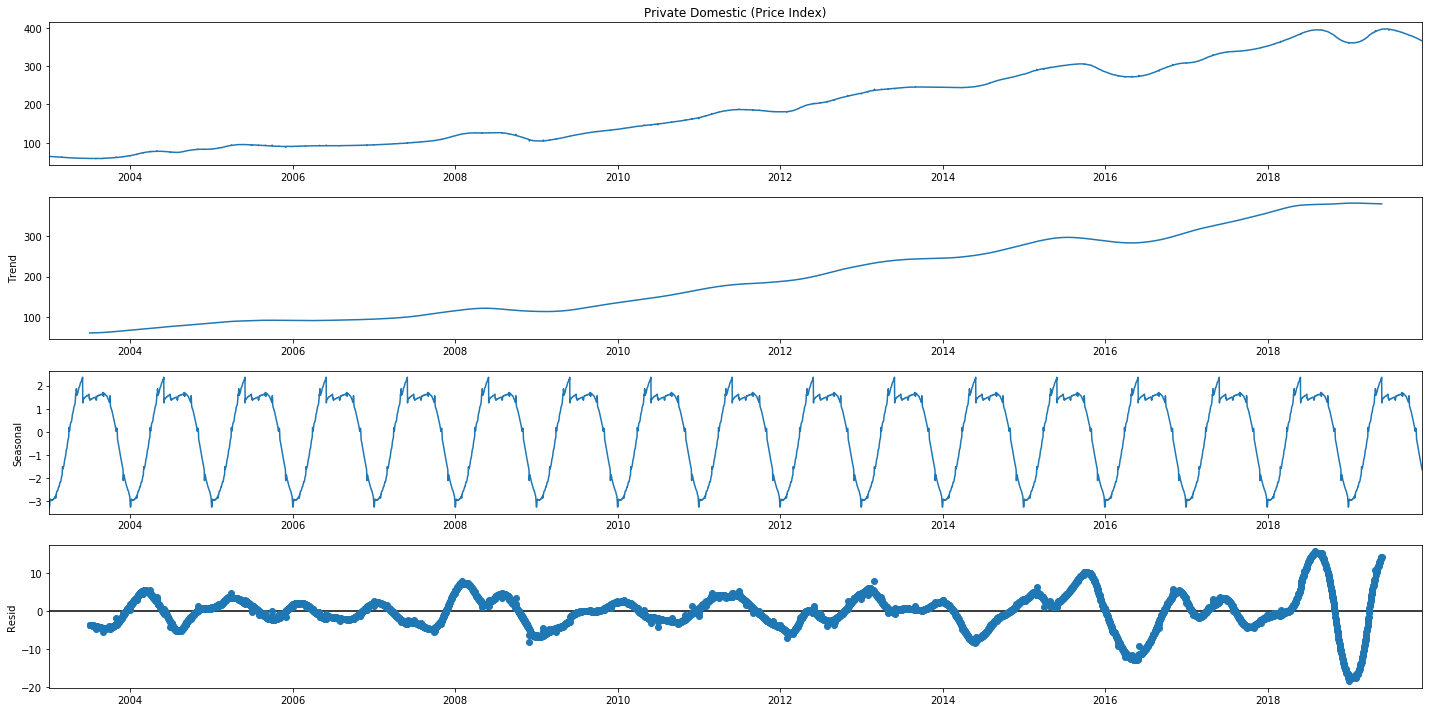

In [83]:
df_series = df.set_index('Date').asfreq('D')
series = pd.Series(df_series['Private Domestic (Price Index)'], index= df_series.index)
results = seasonal_decompose(series, model='additive',freq = 365)
pyplot.rcParams['figure.figsize'] = (20.0, 10.0)
results.plot()
pyplot.show()


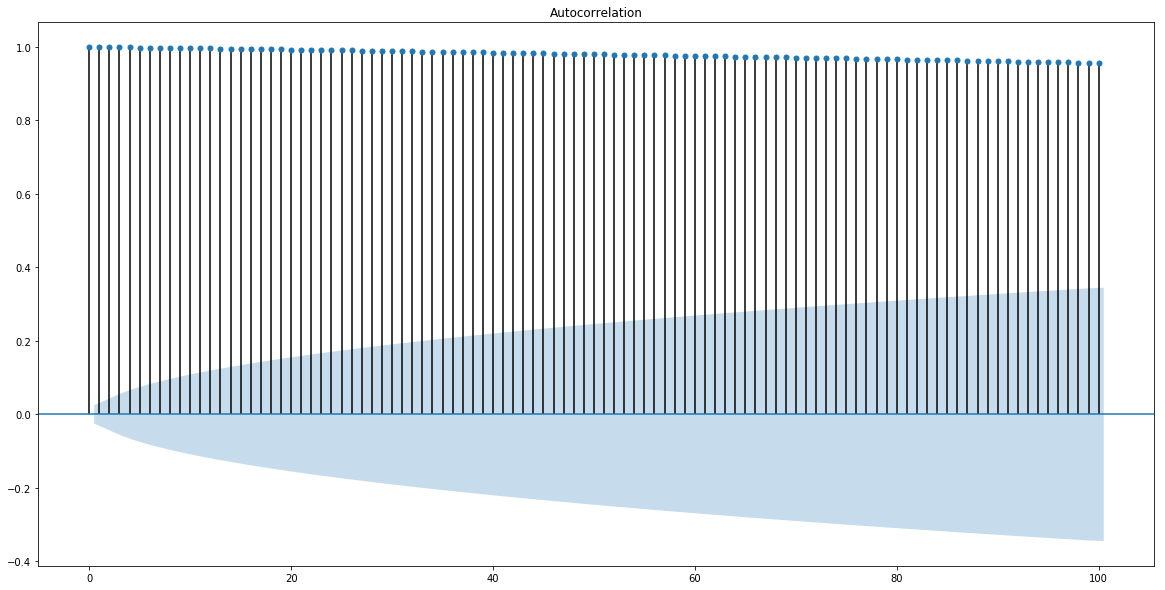

In [84]:
# ACF Plot of Target Variable
plot_acf(series,lags= 100)
pyplot.show()


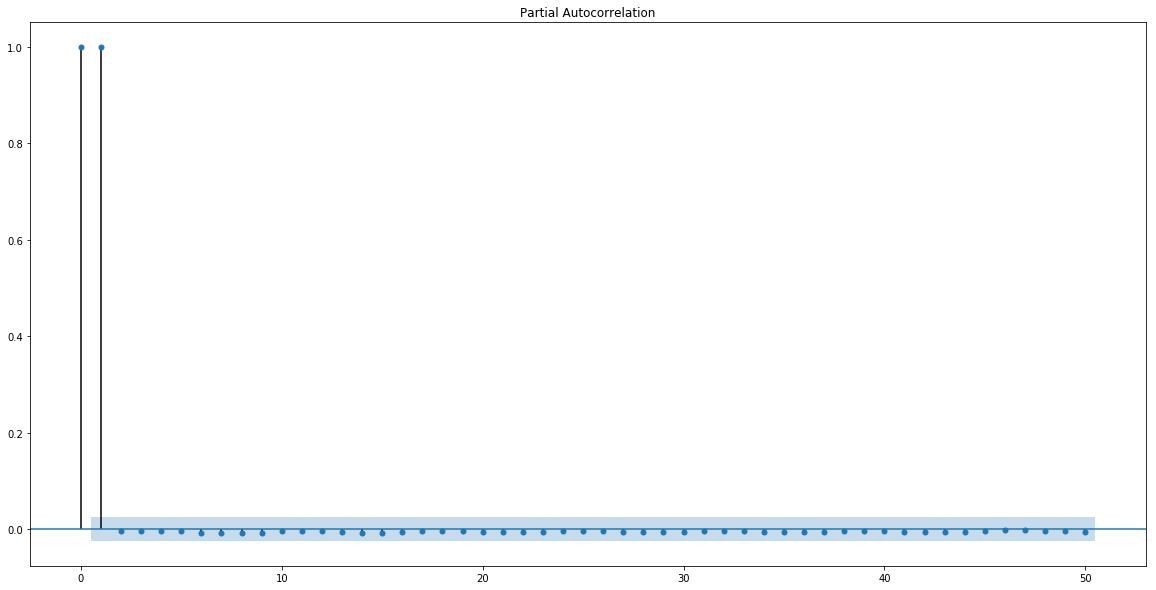

In [85]:
plot_pacf(series, lags=50)
pyplot.show()

##### Feature Engineering
Once the data has been cleaned up, we will create the following additional features:

1. 3 lags for each feature
2. Daily change for each feature
3. A flag for holidays
4. Calculate First hand sales price and drop the sales amount variable

In [86]:
# Create Holiday Flag

df['Date'] = pd.to_datetime(df['Date'])
cal = calendar()
holidays = cal.holidays(start=df['Date'].min(), end=df['Date'].max())
df['holidays'] = pd.np.where(df['Date'].dt.date.isin(holidays), 1, 0)
df.head(5)

C:\Users\ibaruah001\AppData\Local\Annaconda\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  


,Date,Private Domestic (Price Index),First hand sales quantity,First hand sales amount,Total completions,Total stock,Total take up,Total vacancy,Unemployment rate (seasonally adjusted) (%),CPI,HIBOR (1-month),M3 (HK$ million),HSI - close,HSI - volume,holidays
0,2003-01-02,64.559769,1854.689208,5.846897e+09,32744.302914,1.092844e+06,19914.083323,74177.818318,7.301525,73.721486,1.444200,3.562189e+06,9365.519531,126907400.0,0
1,2003-01-03,64.506848,1892.762372,5.927523e+09,32744.302914,1.092244e+06,19900.006814,74155.621001,7.299043,73.717079,1.417410,3.562586e+06,9583.849609,291454400.0,0
4233,2003-01-04,64.489181,1905.621203,5.951307e+09,32744.302914,1.092045e+06,19895.379621,74148.223751,7.298216,73.715614,1.412947,3.562739e+06,9611.219726,272607200.0,0
4234,2003-01-05,64.471514,1918.480035,5.975092e+09,32744.302914,1.091846e+06,19890.752429,74140.826501,7.297389,73.714149,1.408483,3.562891e+06,9638.589844,253760000.0,0
2,2003-01-06,64.453848,1931.338866,5.998876e+09,32744.302914,1.091646e+06,19886.125236,74133.429251,7.296561,73.712684,1.404020,3.563044e+06,9665.959961,234912800.0,0


In [87]:
#Create a new feature =  First hand price
df['First hand sales price'] = df['First hand sales amount']/df['First hand sales quantity']
predictors1 = df.drop(columns=['Date','Private Domestic (Price Index)','holidays','First hand sales amount','First hand sales quantity'],axis=1) # Add  if applicable
predictors1.head(5)

,Total completions,Total stock,Total take up,Total vacancy,Unemployment rate (seasonally adjusted) (%),CPI,HIBOR (1-month),M3 (HK$ million),HSI - close,HSI - volume,First hand sales price
0,32744.302914,1.092844e+06,19914.083323,74177.818318,7.301525,73.721486,1.444200,3.562189e+06,9365.519531,126907400.0,3.152494e+06
1,32744.302914,1.092244e+06,19900.006814,74155.621001,7.299043,73.717079,1.417410,3.562586e+06,9583.849609,291454400.0,3.131678e+06
4233,32744.302914,1.092045e+06,19895.379621,74148.223751,7.298216,73.715614,1.412947,3.562739e+06,9611.219726,272607200.0,3.123027e+06
4234,32744.302914,1.091846e+06,19890.752429,74140.826501,7.297389,73.714149,1.408483,3.562891e+06,9638.589844,253760000.0,3.114493e+06
2,32744.302914,1.091646e+06,19886.125236,74133.429251,7.296561,73.712684,1.404020,3.563044e+06,9665.959961,234912800.0,3.106071e+06


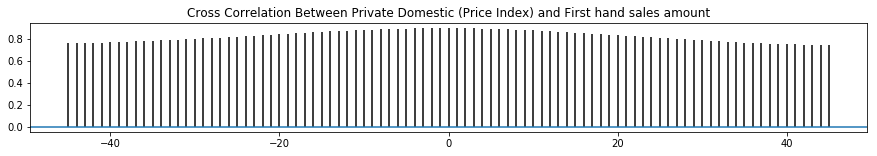

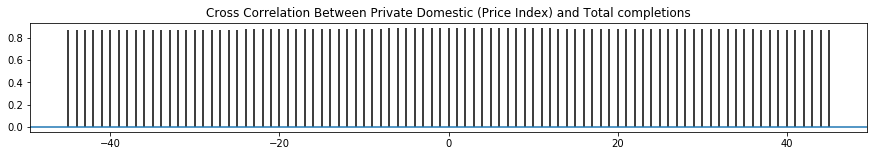

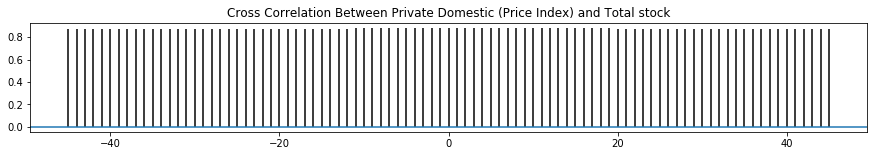

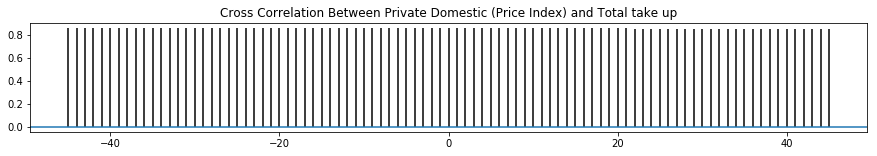

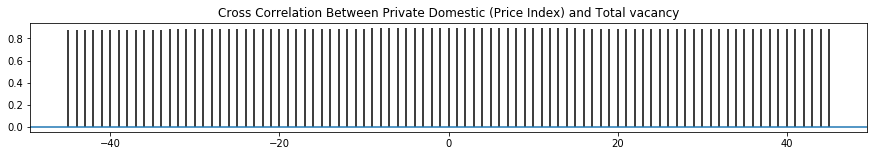

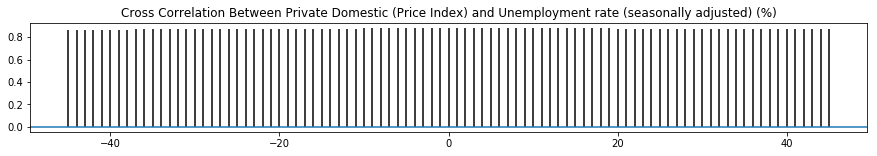

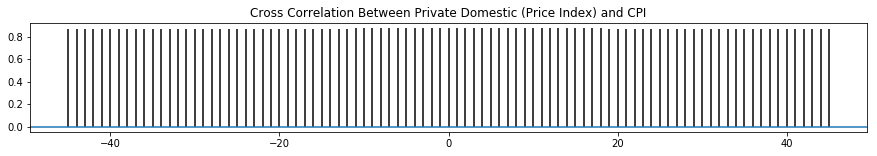

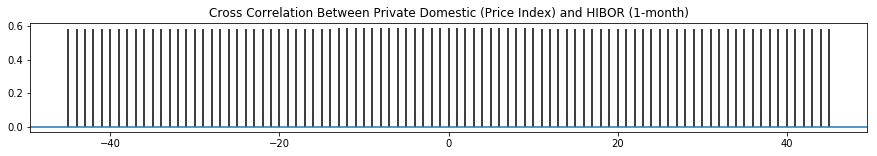

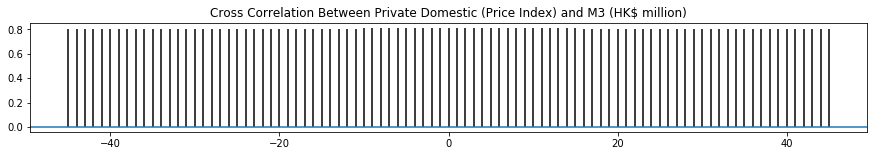

In [88]:
# Check Optimal Number of Lags
for i in range(3,12):
    pyplot.figure(i, figsize=(15,2)) # add this statement before your plot
    pyplot.xcorr(df.iloc[:,2],df.iloc[:,i],maxlags=45, usevlines=1)
    pyplot.title('Cross Correlation Between Private Domestic (Price Index) and '+ df.columns[i])
    pyplot.show()



In [89]:
#Engineering features based on creating lags and perdiodic changes of features

#Add Lags
predictors2 = predictors1.shift(1)
predictors2 = predictors2.add_suffix('_Lag1')
predictors3 = predictors1.shift(2)
predictors3 = predictors3.add_suffix('_Lag2')
predictors4 = predictors1.shift(3)
predictors4 = predictors4.add_suffix('_Lag3')

#Add Periodic Difference
predictors5 = predictors1.diff()
predictors5 = predictors5.add_suffix('_Diff')

predictors = pd.concat([predictors1, predictors2, predictors3,predictors4, predictors5,df['holidays']], axis=1) #Add df['holidays'] if applicable
predictors=predictors.dropna(axis=0, how='any')

predictors.head(10)

,Total completions,Total stock,Total take up,Total vacancy,Unemployment rate (seasonally adjusted) (%),CPI,HIBOR (1-month),M3 (HK$ million),HSI - close,HSI - volume,...,Total take up_Diff,Total vacancy_Diff,Unemployment rate (seasonally adjusted) (%)_Diff,CPI_Diff,HIBOR (1-month)_Diff,M3 (HK$ million)_Diff,HSI - close_Diff,HSI - volume_Diff,First hand sales price_Diff,holidays
4234,32744.302914,1.091846e+06,19890.752429,74140.826501,7.297389,73.714149,1.408483,3.562891e+06,9638.589844,2.537600e+08,...,-4.627192,-7.397250,-0.000827,-0.001465,-0.004463,152.611911,27.370117,-1.884720e+07,-8534.865986,0
2,32744.302914,1.091646e+06,19886.125236,74133.429251,7.296561,73.712684,1.404020,3.563044e+06,9665.959961,2.349128e+08,...,-4.627192,-7.397250,-0.000827,-0.001465,-0.004463,152.611911,27.370117,-1.884720e+07,-8421.215910,0
3,32744.302914,1.091050e+06,19872.438591,74111.243068,7.294081,73.708301,1.390630,3.563562e+06,9652.400391,2.670218e+08,...,-13.686645,-22.186184,-0.002481,-0.004383,-0.013390,518.438226,-13.559570,3.210900e+07,-30096.688654,0
4,32744.302914,1.090457e+06,19858.946877,74089.062450,7.291601,73.703930,1.397320,3.564141e+06,9688.209961,2.024392e+08,...,-13.491713,-22.180617,-0.002480,-0.004371,0.006690,579.040720,35.809570,-6.458260e+07,-34301.973468,0
5,32744.302914,1.089865e+06,19845.650096,74066.887400,7.289122,73.699570,1.430800,3.564781e+06,9675.410156,1.296232e+08,...,-13.296781,-22.175051,-0.002479,-0.004360,0.033480,639.643214,-12.799805,-7.281600e+07,-38238.405936,0
6,32744.302914,1.089275e+06,19832.548246,74044.717915,7.286643,73.695223,1.439730,3.565481e+06,9721.500000,1.728622e+08,...,-13.101850,-22.169484,-0.002478,-0.004348,0.008930,700.245708,46.089844,4.323900e+07,-41920.790237,0
4235,32744.302914,1.089080e+06,19828.245940,74037.329943,7.285817,73.693777,1.436010,3.565735e+06,9759.026693,1.812307e+08,...,-4.302306,-7.387973,-0.000826,-0.001445,-0.003720,253.616067,37.526693,8.368467e+06,-15317.896731,0
4236,32744.302914,1.088884e+06,19823.943634,74029.941970,7.284991,73.692332,1.432290,3.565988e+06,9796.553385,1.895991e+08,...,-4.302306,-7.387973,-0.000826,-0.001445,-0.003720,253.616067,37.526693,8.368467e+06,-15119.773112,0
7,32744.302914,1.088688e+06,19819.641329,74022.553998,7.284165,73.690887,1.428570,3.566242e+06,9834.080078,1.979676e+08,...,-4.302306,-7.387973,-0.000826,-0.001445,-0.003720,253.616067,37.526693,8.368467e+06,-14925.468628,0
8,32744.302914,1.088102e+06,19806.929343,74000.395646,7.281688,73.686562,1.433040,3.567063e+06,9796.309570,1.681520e+08,...,-12.711986,-22.158351,-0.002477,-0.004324,0.004470,821.450696,-37.770508,-2.981560e+07,-48578.710184,0


In [90]:
# Checking the final predictors data
predictors.describe()

,Total completions,Total stock,Total take up,Total vacancy,Unemployment rate (seasonally adjusted) (%),CPI,HIBOR (1-month),M3 (HK$ million),HSI - close,HSI - volume,...,Total take up_Diff,Total vacancy_Diff,Unemployment rate (seasonally adjusted) (%)_Diff,CPI_Diff,HIBOR (1-month)_Diff,M3 (HK$ million)_Diff,HSI - close_Diff,HSI - volume_Diff,First hand sales price_Diff,holidays
count,6170.000000,6.170000e+03,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6.170000e+03,6170.000000,6.170000e+03,...,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6170.000000,6.170000e+03,6.170000e+03,6170.000000
mean,15361.946209,1.106765e+06,13925.085988,52796.789304,4.197309,88.223190,1.103977,8.386498e+06,20802.897798,1.453729e+09,...,-3.493241,-0.848153,-0.000655,0.005887,0.000106,1731.692209,2.804327,3.474530e+05,8.058516e+02,0.000162
std,6386.221684,5.070278e+04,6173.995838,8987.318195,1.267338,12.709861,1.257734,3.551502e+06,5295.961619,8.001701e+08,...,23.476645,19.673321,0.118831,0.226253,0.113443,4928.887779,209.760663,3.312027e+08,4.143880e+05,0.012731
min,6792.576078,1.006630e+06,-1657.914651,41975.928483,2.800000,71.700000,0.040180,3.548561e+06,8409.009766,0.000000e+00,...,-86.777479,-58.464668,-1.391505,-3.448806,-2.151193,-27648.009925,-2061.228516,-1.711519e+09,-1.656848e+07,0.000000
25%,9943.585825,1.073241e+06,9518.075367,45722.582067,3.136487,75.570224,0.213570,5.290837e+06,17083.933106,9.291716e+08,...,-12.697966,-9.006723,-0.001276,0.002268,-0.003965,-376.322723,-71.925781,-1.312109e+08,-4.417888e+04,0.000000
50%,13761.512667,1.106819e+06,12662.876161,49958.656160,3.643848,86.249741,0.347573,7.668805e+06,21655.020508,1.497364e+09,...,-0.106193,-2.379272,-0.000483,0.004488,0.000000,1122.499073,7.116211,-9.377533e+06,-4.408809e+02,0.000000
75%,19061.267131,1.142407e+06,16988.427021,62792.720675,5.054313,100.307746,1.747771,1.147976e+07,23949.367350,1.940716e+09,...,8.903788,2.886277,-0.000048,0.011017,0.002463,3529.909155,87.710286,1.151925e+08,4.535706e+04,0.000000
max,32744.302914,1.214837e+06,28187.536217,74140.826501,7.800000,111.000000,4.047737,1.470108e+07,33154.121094,3.467110e+09,...,58.243255,97.903823,1.359147,3.400005,1.991575,34181.322349,2332.539063,1.984283e+09,2.214944e+07,1.000000


In [91]:
#Setting up Target field
Target = df.iloc[3: , [1]]
Target.head(5)

,Private Domestic (Price Index)
4234,64.471514
2,64.453848
3,64.400768
4,64.347610
5,64.294373


#### Feature Selection
The next step is to perform featue selection using the following techniques:
1. Select the top n features based on feature importance from random forest
2. Select the top n features based on absolute correlation with target variable
3. Select the features identified by Lasso regression
4. Perform recursive feature selection and use cross validation to identify the best number of features
5. Select the top n features based on absolute value of beta coefficients of features

The final features are the ones which were selected in at least 3 out of 5 models.


C:\Users\ibaruah001\AppData\Local\Annaconda\lib\site-packages\ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


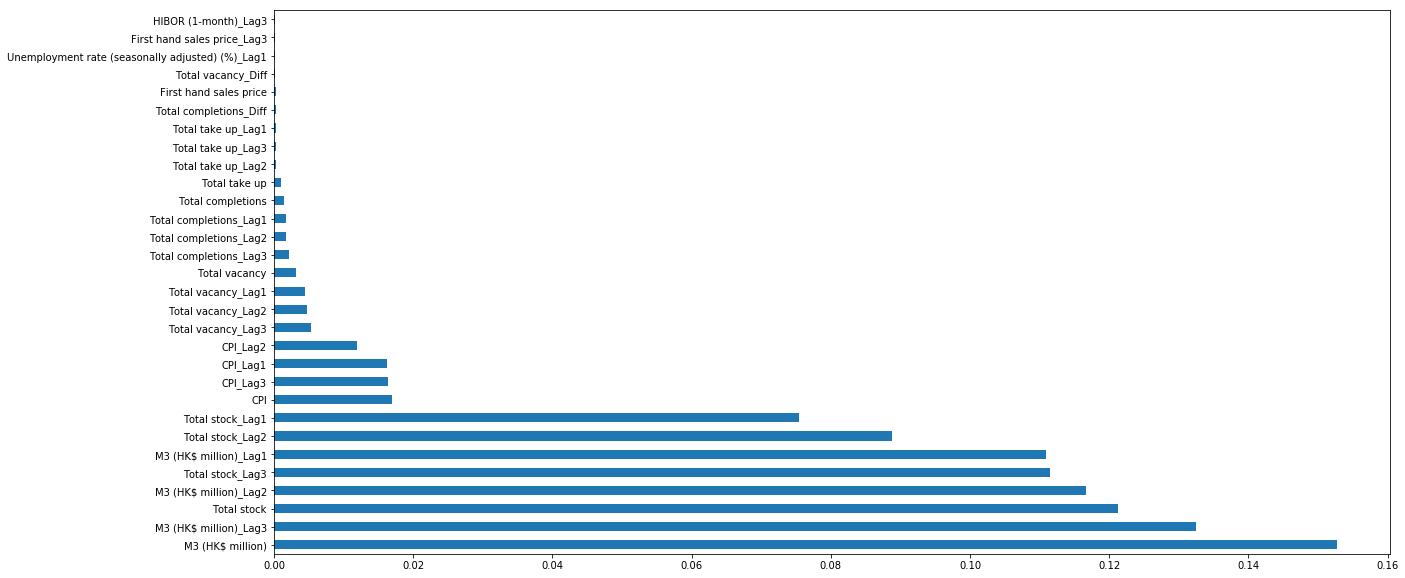

In [92]:
#1.Select the top n features based on feature importance from random forest

np.random.seed(10)

# define the model
model = RandomForestRegressor(random_state = random.seed(10))
# fit the model
model.fit(predictors, Target)

# get importance
features = predictors
importances = model.feature_importances_
indices = np.argsort(importances)

feat_importances = pd.Series(model.feature_importances_, index=predictors.columns)
feat_importances.nlargest(30).plot(kind='barh')





In [93]:
#Final Features from Random Forest (Select Features with highest feature importance)
rf_top_features = pd.DataFrame(feat_importances.nlargest(7)).axes[0].tolist()

In [94]:
#2.Select the top n features based on absolute correlation with target variable
corr_data1 = pd.concat([Target,predictors],axis = 1)
corr_data = corr_data1.corr()
corr_data = corr_data.iloc[: , [0]]
corr_data.columns.values[0] = "Correlation"
corr_data = corr_data.iloc[corr_data.Correlation.abs().argsort()] 
corr_data = corr_data[corr_data['Correlation'].notna()]
corr_data = corr_data.loc[corr_data['Correlation'] != 1]
corr_data.tail(20)



,Correlation
HSI - close,0.798105
HSI - close_Lag1,0.798300
HSI - close_Lag2,0.798492
HSI - close_Lag3,0.798681
Unemployment rate (seasonally adjusted) (%),-0.839675
Unemployment rate (seasonally adjusted) (%)_Lag1,-0.839772
Unemployment rate (seasonally adjusted) (%)_Lag2,-0.839865
Unemployment rate (seasonally adjusted) (%)_Lag3,-0.839958
Total stock_Lag3,0.959957
Total stock_Lag2,0.960064


In [95]:
# Select Features with greater than 90% absolute correlation
corr_data2 = corr_data.loc[corr_data['Correlation'].abs() > .9]
corr_top_features = corr_data2.axes[0].tolist()

In [96]:
#3.Select the features identified by Lasso regression

np.random.seed(10)

estimator = LassoCV(cv=5, normalize = True)

sfm = SelectFromModel(estimator, prefit=False, norm_order=1, max_features=None)

sfm.fit(predictors, Target)

feature_idx = sfm.get_support()
Lasso_features = predictors.columns[feature_idx].tolist()
Lasso_features

C:\Users\ibaruah001\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\ibaruah001\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12330.10323860118, tolerance: 6697.469916266773
  positive)


['Total completions',
 'CPI',
 'HSI - close',
 'Unemployment rate (seasonally adjusted) (%)_Lag1',
 'CPI_Lag1',
 'HSI - close_Lag1',
 'Total completions_Lag2',
 'Unemployment rate (seasonally adjusted) (%)_Lag2',
 'CPI_Lag2',
 'Total completions_Lag3',
 'Total take up_Lag3',
 'Unemployment rate (seasonally adjusted) (%)_Lag3',
 'CPI_Lag3',
 'HSI - close_Lag3',
 'Total completions_Diff',
 'Total stock_Diff',
 'Total take up_Diff',
 'Total vacancy_Diff',
 'CPI_Diff',
 'M3 (HK$ million)_Diff']

In [97]:
#4.Perform recursive feature selection and use cross validation to identify the best number of features

#Feature ranking with recursive feature elimination and cross-validated selection of the best number of features

rfe_selector = RFE(estimator=LinearRegression(), n_features_to_select= 7, step=10, verbose=5)
rfe_selector.fit(predictors, Target)
rfe_support = rfe_selector.get_support()
rfe_feature = predictors.loc[:,rfe_support].columns.tolist()
rfe_feature

Fitting estimator with 56 features.
Fitting estimator with 46 features.
Fitting estimator with 36 features.
Fitting estimator with 26 features.
Fitting estimator with 16 features.


['CPI',
 'CPI_Lag1',
 'HIBOR (1-month)_Lag1',
 'CPI_Lag2',
 'CPI_Lag3',
 'HIBOR (1-month)_Diff',
 'holidays']

In [98]:
#5.Select the top n features based on absolute value of beta coefficients of features

# define standard scaler
scaler = StandardScaler()
# transform x data
scaled_predictors = scaler.fit_transform(predictors)
scaled_Target = scaler.fit_transform(Target)

sr_reg = LinearRegression(fit_intercept = False).fit(scaled_predictors, scaled_Target)
coef_table = pd.DataFrame(list(predictors.columns)).copy()
coef_table.insert(len(coef_table.columns),"Coefs",sr_reg.coef_.transpose())
coef_table = coef_table.iloc[coef_table.Coefs.abs().argsort()] 


sr_data2 = coef_table.tail(10)
sr_top_features = sr_data2.iloc[:,0].tolist()
sr_top_features

['M3 (HK$ million)_Lag1',
 'M3 (HK$ million)',
 'Unemployment rate (seasonally adjusted) (%)',
 'Unemployment rate (seasonally adjusted) (%)_Lag1',
 'Total completions',
 'Total completions_Lag1',
 'Total stock_Lag1',
 'Total stock',
 'Total take up_Lag1',
 'Total take up']

In [99]:
# Combining features from all the models

combined_feature_list = sr_top_features + Lasso_features + corr_top_features + rf_top_features

combined_feature = {x:combined_feature_list.count(x) for x in combined_feature_list}
combined_feature_data = pd.DataFrame.from_dict(combined_feature,orient='index')

combined_feature_data.rename(columns={ combined_feature_data.columns[0]: "number_of_models" }, inplace = True)


combined_feature_data = combined_feature_data.sort_values(['number_of_models'], ascending=[False])

combined_feature_data.head(100)

,number_of_models
M3 (HK$ million)_Lag1,3
M3 (HK$ million),3
Total stock,3
CPI,2
M3 (HK$ million)_Lag2,2
Total stock_Lag2,2
Total stock_Lag3,2
CPI_Lag3,2
CPI_Lag1,2
CPI_Lag2,2


In [100]:
#Final Features: features which were selected in atleast 3 models

combined_feature_data = combined_feature_data.loc[combined_feature_data['number_of_models'] > 2]
final_features = combined_feature_data.axes[0].tolist()
final_features

['M3 (HK$ million)_Lag1', 'M3 (HK$ million)', 'Total stock']

### Data Preparation for Forecasting Engine

In [101]:
# Final Master Data on Selected Features
features = predictors[predictors.columns.intersection(final_features)]
features_date =  df.iloc[3:,0]
features_final = features.set_index(features_date).asfreq('D')
features_final.head(10)                                           

,Total stock,M3 (HK$ million),M3 (HK$ million)_Lag1
Date,,,
2003-01-05,1.091846e+06,3.562891e+06,3.562739e+06
2003-01-06,1.091646e+06,3.563044e+06,3.562891e+06
2003-01-07,1.091050e+06,3.563562e+06,3.563044e+06
2003-01-08,1.090457e+06,3.564141e+06,3.563562e+06
2003-01-09,1.089865e+06,3.564781e+06,3.564141e+06
2003-01-10,1.089275e+06,3.565481e+06,3.564781e+06
2003-01-11,1.089080e+06,3.565735e+06,3.565481e+06
2003-01-12,1.088884e+06,3.565988e+06,3.565735e+06
2003-01-13,1.088688e+06,3.566242e+06,3.565988e+06


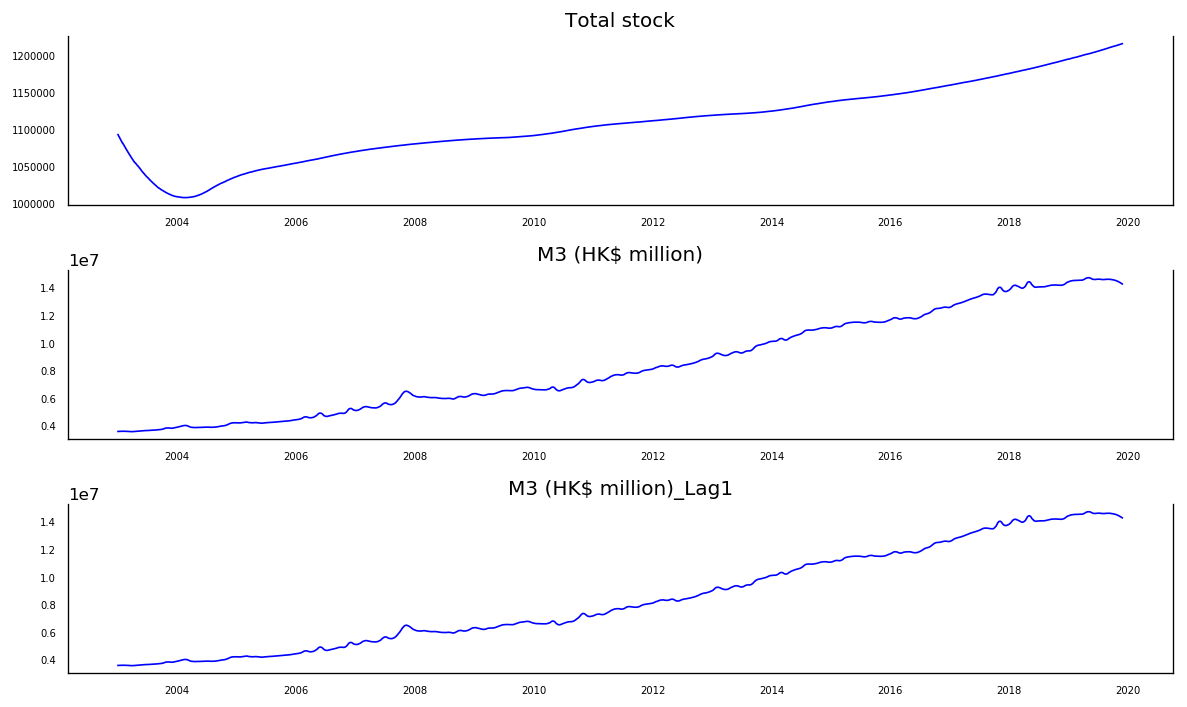

In [102]:
# Plot all Final Features
fig, axes = pyplot.subplots(nrows=3, ncols=1, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    plot_data = features_final[features_final.columns[i]]
    ax.plot(plot_data, color='blue', linewidth=1)
    # Decorations
    ax.set_title(features_final.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

pyplot.tight_layout();

In [103]:
# Final Target Variable Dataset
target_final = series.iloc[3:,]
target_final.tail(5)

Date
2019-11-22    366.678619
2019-11-23    366.534478
2019-11-24    366.390336
2019-11-25    366.246194
2019-11-26    365.810997
Freq: D, Name: Private Domestic (Price Index), dtype: float64

#### Univariate Time Series

In [135]:
# Holt Winter’s Exponential Smoothing (HWES)or Triple Smoothing
# fit model

random.seed(10)

model = ExponentialSmoothing(series, trend = 'add',seasonal= 'add', seasonal_periods= 7)
model_fit = model.fit()
# make prediction
HWES_Forecast = pd.DataFrame(model_fit.forecast(steps=365))
HWES_Forecast.columns = ['HWES_Forecast']
HWES_Forecast.head(5)


#Plot
#HWES_Forecast.plot(marker='o', color='red', legend=True)
#model_fit.fittedvalues.plot(marker='o',  color='blue')

C:\Users\ibaruah001\AppData\Local\Annaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:725: RuntimeWarning: invalid value encountered in less_equal
  loc = initial_p <= lb
C:\Users\ibaruah001\AppData\Local\Annaconda\lib\site-packages\statsmodels\tsa\holtwinters.py:731: RuntimeWarning: invalid value encountered in greater_equal
  loc = initial_p >= ub


,HWES_Forecast
2019-11-27,365.584796
2019-11-28,365.319148
2019-11-29,365.063393
2019-11-30,364.761805
2019-12-01,364.444793


In [105]:
# fitting a stepwise model to find the best paramters for SARIMA:
stepwise_fit = pm.auto_arima(target_final, start_p=1, start_q=1, max_p=3, max_d=2,max_q=3,m=7,
                             start_P=0,start_Q=0,max_P=3, max_D=3,max_Q=3, seasonal=True, trace=True,
                             error_action='ignore',  # don't want to know if an order does not work
                             suppress_warnings=True,  # don't want convergence warnings
                             stepwise=True)  # set to stepwise

stepwise_fit.summary()


Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[7]             : AIC=-197.062, Time=1.42 sec
 ARIMA(0,2,0)(0,0,0)[7]             : AIC=5058.119, Time=0.23 sec
 ARIMA(1,2,0)(1,0,0)[7]             : AIC=3074.520, Time=1.06 sec
 ARIMA(0,2,1)(0,0,1)[7]             : AIC=0.776, Time=1.85 sec
 ARIMA(1,2,1)(1,0,0)[7]             : AIC=-230.999, Time=2.31 sec
 ARIMA(1,2,1)(2,0,0)[7]             : AIC=-265.196, Time=5.17 sec
 ARIMA(1,2,1)(3,0,0)[7]             : AIC=-292.867, Time=9.47 sec
 ARIMA(1,2,1)(3,0,1)[7]             : AIC=-338.219, Time=21.87 sec
 ARIMA(1,2,1)(2,0,1)[7]             : AIC=-339.959, Time=9.65 sec
 ARIMA(1,2,1)(1,0,1)[7]             : AIC=-340.231, Time=5.27 sec
 ARIMA(1,2,1)(0,0,1)[7]             : AIC=-226.245, Time=2.27 sec
 ARIMA(1,2,1)(1,0,2)[7]             : AIC=-339.988, Time=11.16 sec
 ARIMA(1,2,1)(0,0,2)[7]             : AIC=-254.390, Time=5.05 sec
 ARIMA(1,2,1)(2,0,2)[7]             : AIC=-336.264, Time=11.90 sec
 ARIMA(0,2,1)(1,0,1)[7]          

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                      y   No. Observations:                 6170
Model:             SARIMAX(3, 2, 1)x(1, 0, [1, 2], 7)   Log Likelihood                 382.734
Date:                                Fri, 25 Sep 2020   AIC                           -749.468
Time:                                        10:32:42   BIC                           -695.651
Sample:                                             0   HQIC                          -730.805
                                               - 6170                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3012      0.005    -57.764      0.000      -0.311      -0.291
ar.L2         -0.2482      0.007    -35.581      0.000      -0.262      -0.235
ar.L3         -0.1778      0.008    -22.832      0.000      -0.193      -0.163
ma.L1         -0.9392      0.004   -226.455      0.000      -0.947      -0.931
ar.S.L7        0.8677      0.025     34.616      0.000       0.819       0.917
ma.S.L7       -0.7997      0.030    -26.803      0.000      -0.858      -0.741
ma.S.L14       0.0216      0.020      1.096      0.273      -0.017       0.060
sigma2         0.0517      0.000    243.205      0.000       0.051       0.052
===================================================================================
Ljung-Box (Q):                      298.30   Jarque-Bera (JB):            480097.01
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.43   Skew:                             0.78
Prob(H) (two-sided):                  0.00   Kurtosis:                        46.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [136]:
# SARIMA 

# Using parameters automatically based on grid serach
SARIMA_Forecast = pd.DataFrame(stepwise_fit.predict(n_periods= 365))
SARIMA_Forecast.columns = ['SARIMA_Forecast']
SARIMA_Forecast.index = HWES_Forecast.index
SARIMA_Forecast.head(5)


# Manually fit the model
#sarima_model = SARIMAX(series, order=(5, 2, 2), seasonal_order=(0, 0, 1, 7))
#sarima_model_fit = sarima_model.fit(disp=False)
# make prediction
#SARIMA_Forecast = model_fit.predict(len(data), len(data))
#print(yhat)

,SARIMA_Forecast
2019-11-27,365.470756
2019-11-28,365.143184
2019-11-29,364.820468
2019-11-30,364.575509
2019-12-01,364.329815


### Data Prep for multivariate models

In [107]:
# Function to check stationarity

def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.") 

In [108]:
# Data Prep

AI_Model_data = pd.concat([target_final, features_final], axis=1, sort=False)

# Check stationarity

# ADF Test on each column
for name, column in AI_Model_data.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Private Domestic (Price Index)" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -1.2294
 No. Lags Chosen       = 34
 Critical value 1%     = -3.431
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.6608. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "Total stock" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -1.982
 No. Lags Chosen       = 33
 Critical value 1%     = -3.431
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.2945. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "M3 (HK$ million)" 
    ------------------------------------

In [180]:

# 1st difference
AI_Model_data_differenced = AI_Model_data.diff().dropna()


# Check stationarity

# ADF Test on each column
#for name, column in AI_Model_data_differenced.iteritems():
    #adfuller_test(column, name=column.name)
    #print('\n')

x = AI_Model_data_differenced.values #returns a numpy array


# Standardise Datasets

standard_scaler = StandardScaler()
x_scaled = standard_scaler.fit_transform(x)
scaled_AI_Model_data = pd.DataFrame(x_scaled)
scaled_AI_Model_data.columns = AI_Model_data_differenced.columns



# Check stationarity on diffrenced and scaled data

# ADF Test on each column
for name, column in scaled_AI_Model_data.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Private Domestic (Price Index)" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -3.6108
 No. Lags Chosen       = 33
 Critical value 1%     = -3.431
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0056. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Total stock" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -8.7666
 No. Lags Chosen       = 34
 Critical value 1%     = -3.431
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "M3 (HK$ million)" 
    -----------------------------------------------
 Null Hypothesis: Data has unit ro

In [109]:
# Separate out traget and features

scaled_AI_Model_Target = scaled_AI_Model_data.iloc[:,0]
scaled_AI_Model_Features = scaled_AI_Model_data.iloc[:,1:]

#Mean and Standard Deviation
mean_target = AI_Model_data_differenced.iloc[:,0].mean()
std_target = AI_Model_data_differenced.iloc[:,0].std()


scaled_AI_Model_Features

,Total stock,M3 (HK$ million),M3 (HK$ million)_Lag1
0,-2.757881,-0.320427,-0.320983
1,-7.745738,-0.246206,-0.320983
2,-7.719380,-0.233910,-0.246720
3,-7.693022,-0.221615,-0.234418
4,-7.666664,-0.209319,-0.222116
...,...,...,...
6164,0.996238,-2.568317,-2.531685
6165,0.165155,-1.103174,-2.570131
6166,0.165155,-1.103174,-1.104168
6167,0.165155,-1.103174,-1.104168


In [110]:
# Train Test Split

nobs = 365
features_train, features_test = scaled_AI_Model_Features[0:-nobs], features_final[-nobs:]
target_train, target_test = scaled_AI_Model_Target[0:-nobs], target_final[-nobs:]

# Check size
print(features_train.shape)  # (5805, 9)
print(features_test.shape)  # (365, 9)
print(target_train.shape)  # (5805, )
print(target_test.shape)  # (365, )

(5804, 3)
(365, 3)
(5804,)
(365,)


In [111]:
#Driver Forecast using SARIMA

forecast_index = pd.date_range('2019/11/27', '2020/11/25')

driver_forecasts = pd.DataFrame(index=forecast_index, columns= features_final.columns)

scaled_AI_Model_Features_1 = scaled_AI_Model_Features.copy()
date_index = pd.date_range('2003-01-06', '2019/11/26')
scaled_AI_Model_Features_1.index = date_index


for i in range(len(features_final.columns)):


                                            df_series = scaled_AI_Model_Features_1.asfreq('D')
                                            series_features = pd.Series(df_series.iloc[:,i], index= df_series.index)

                                            stepwise_fit_features = pm.auto_arima(series_features, start_p=1, start_q=1, max_p=2, max_d=2,max_q=2,m=7,
                                                                         start_P=0,start_Q=0,max_P=2, max_D=2,max_Q=2, seasonal=True, trace=True,
                                                                         error_action='ignore',  # don't want to know if an order does not work
                                                                         suppress_warnings=True,  # don't want convergence warnings
                                                                         stepwise=True)  # set to stepwise

                                            SARIMA_Forecast_features = stepwise_fit_features.predict(n_periods= 365)
                                            #Add to driver forecast dataset
                                            driver_forecasts.iloc[:,i] = SARIMA_Forecast_features

driver_forecasts.head(5)


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[7] intercept   : AIC=6763.340, Time=3.74 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=8526.451, Time=0.51 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=1680.008, Time=7.21 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=5447.930, Time=5.03 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=8524.461, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=8526.053, Time=0.57 sec
 ARIMA(1,1,0)(2,0,0)[7] intercept   : AIC=inf, Time=9.91 sec
 ARIMA(1,1,0)(1,0,1)[7] intercept   : AIC=-845.626, Time=10.14 sec
 ARIMA(1,1,0)(0,0,1)[7] intercept   : AIC=5485.680, Time=3.09 sec
 ARIMA(1,1,0)(2,0,1)[7] intercept   : AIC=-851.121, Time=26.03 sec
 ARIMA(1,1,0)(2,0,2)[7] intercept   : AIC=inf, Time=28.14 sec
 ARIMA(1,1,0)(1,0,2)[7] intercept   : AIC=-852.629, Time=21.29 sec
 ARIMA(1,1,0)(0,0,2)[7] intercept   : AIC=4078.019, Time=6.08 sec
 ARIMA(0,1,0)(1,0,2)[7] intercept   : AIC=-153.096, Time=18.92 sec
 ARIMA(2,1,0)(1,0,2)[7] intercept   : 

 ARIMA(2,1,2)(2,0,1)[7] intercept   : AIC=4590.451, Time=34.35 sec
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=4565.072, Time=17.30 sec
 ARIMA(1,1,2)(2,0,2)[7] intercept   : AIC=4456.105, Time=33.29 sec
 ARIMA(2,1,2)(2,0,2)[7]             : AIC=4298.112, Time=14.19 sec
 ARIMA(2,1,2)(1,0,2)[7]             : AIC=4422.177, Time=14.42 sec
 ARIMA(2,1,2)(2,0,1)[7]             : AIC=4588.043, Time=15.24 sec
 ARIMA(2,1,2)(1,0,1)[7]             : AIC=4562.601, Time=5.29 sec
 ARIMA(1,1,2)(2,0,2)[7]             : AIC=4453.708, Time=11.14 sec
 ARIMA(2,1,1)(2,0,2)[7]             : AIC=4448.711, Time=10.04 sec
 ARIMA(1,1,1)(2,0,2)[7]             : AIC=4456.967, Time=11.54 sec

Best model:  ARIMA(2,1,2)(2,0,2)[7]          
Total fit time: 490.828 seconds


,Total stock,M3 (HK$ million),M3 (HK$ million)_Lag1
2019-11-27,0.997198,-2.682884,-2.086517
2019-11-28,1.008067,-2.544874,-2.269493
2019-11-29,1.000226,-2.385175,-2.293428
2019-11-30,0.185239,-1.503105,-2.221118
2019-12-01,0.176910,-1.511373,-1.332827


#### Multivariate Time Series

In [176]:
# fitting a stepwise model to find the best paramters for SARIMAX:
stepwise_fit_2 = pm.auto_arima(scaled_AI_Model_Target, start_p=1, start_q=1, max_p=3, d=0,max_q=3,m=7,
                             start_P=0,start_Q=0,max_P=3, max_D=3,max_Q=3, seasonal=True, trace=True,
                             error_action='ignore',  # don't want to know if an order does not work
                             suppress_warnings=True,  # don't want convergence warnings
                             stepwise=True)  # set to stepwise

stepwise_fit_2.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[7] intercept   : AIC=16602.803, Time=3.10 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=17510.864, Time=0.11 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=17167.608, Time=1.02 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=17275.372, Time=1.16 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=17508.864, Time=0.06 sec
 ARIMA(1,0,1)(1,0,0)[7] intercept   : AIC=17166.628, Time=2.44 sec
 ARIMA(1,0,1)(0,0,1)[7] intercept   : AIC=17276.799, Time=2.71 sec
 ARIMA(1,0,1)(1,0,1)[7] intercept   : AIC=16441.930, Time=5.55 sec
 ARIMA(1,0,1)(2,0,1)[7] intercept   : AIC=16424.847, Time=13.36 sec
 ARIMA(1,0,1)(2,0,0)[7] intercept   : AIC=16839.488, Time=7.39 sec
 ARIMA(1,0,1)(3,0,1)[7] intercept   : AIC=16419.292, Time=23.24 sec
 ARIMA(1,0,1)(3,0,0)[7] intercept   : AIC=16591.933, Time=14.88 sec
 ARIMA(1,0,1)(3,0,2)[7] intercept   : AIC=16417.786, Time=61.29 sec
 ARIMA(1,0,1)(2,0,2)[7] intercept   : AIC=16335.456, Time=28.18 sec
 ARIMA(1,0,1)(

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                 6169
Model:             SARIMAX(2, 0, 2)x(2, 0, 2, 7)   Log Likelihood               -7724.880
Date:                           Sun, 27 Sep 2020   AIC                          15467.760
Time:                                   01:01:34   BIC                          15528.306
Sample:                                        0   HQIC                         15488.756
                                          - 6169                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.5266      0.010    150.004      0.000       1.507       1.547
ar.L2         -0.5291      0.010    -52.027      0.000      -0.549      -0.509
ma.L1         -1.8482      0.008   -217.621      0.000      -1.865      -1.832
ma.L2          0.8704      0.008    104.301      0.000       0.854       0.887
ar.S.L7        1.7879      0.068     26.442      0.000       1.655       1.920
ar.S.L14      -0.8237      0.061    -13.533      0.000      -0.943      -0.704
ma.S.L7       -1.7557      0.064    -27.511      0.000      -1.881      -1.631
ma.S.L14       0.8060      0.054     14.988      0.000       0.701       0.911
sigma2         0.7159      0.003    235.346      0.000       0.710       0.722
===================================================================================
Ljung-Box (Q):                       84.40   Jarque-Bera (JB):            526608.99
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.43   Skew:                             0.83
Prob(H) (two-sided):                  0.00   Kurtosis:                        48.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [182]:
# SARIMAX 
# contrived dataset
data1 = scaled_AI_Model_Target
data2 = scaled_AI_Model_Features
# fit model
model = SARIMAX(data1, exog=data2, order=stepwise_fit_2.order, seasonal_order=stepwise_fit_2.seasonal_order)
model_fit = model.fit(disp=False)
# make prediction
exog2 = driver_forecasts
SARIMAX_Forecast = pd.DataFrame(model_fit.predict(len(data1),len(data1)+364, exog=exog2))
SARIMAX_Forecast.columns = ['Raw_Forecast']
SARIMAX_Forecast['SARIMAX_Forecast_De_Standardise_R_Sum'] = SARIMAX_Forecast['Raw_Forecast'].cumsum()
SARIMAX_Forecast['SARIMAX_Forecast'] = SARIMAX_Forecast['SARIMAX_Forecast_De_Standardise_R_Sum'] + Latest_target[0]

SARIMAX_Forecast.index = HWES_Forecast.index
SARIMAX_Forecast.head(5)
#print(SARIMAX_Forecast)

C:\Users\ibaruah001\AppData\Local\Annaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\ibaruah001\AppData\Local\Annaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\ibaruah001\AppData\Local\Annaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


,Raw_Forecast,SARIMAX_Forecast_De_Standardise_R_Sum,SARIMAX_Forecast
2019-11-27,-1.336010,-1.336010,364.474987
2019-11-28,-1.395018,-2.731028,363.079969
2019-11-29,-1.404494,-4.135522,361.675475
2019-11-30,-1.083855,-5.219377,360.591620
2019-12-01,-1.106740,-6.326117,359.484880


In [181]:
# Data Prep for VAR/VECM - First Difference and check stationarity

# Data Prep for VAR - check stationarity

varma_vecm_data = pd.concat([target_final, features_final], axis=1, sort=False)
varma_vecm_data  = varma_vecm_data.drop(columns=['M3 (HK$ million)_Lag1'])

# 1st difference
varma_vecm_data_differenced = varma_vecm_data.diff().dropna()

# ADF Test on each column
for name, column in varma_vecm_data_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')


    Augmented Dickey-Fuller Test on "Private Domestic (Price Index)" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -3.6108
 No. Lags Chosen       = 33
 Critical value 1%     = -3.431
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0056. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Total stock" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -8.7666
 No. Lags Chosen       = 34
 Critical value 1%     = -3.431
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "M3 (HK$ million)" 
    -----------------------------------------------
 Null Hypothesis: Data has unit ro

In [140]:
#VAR Model

model = VAR(varma_vecm_data_differenced)
lag_selection_VAR = model.select_order(maxlags=12)

list(lag_selection_VAR.selected_orders.values())[0]


# Get the lag order
lag_order = list(lag_selection_VAR.selected_orders.values())[0]

model_fitted = model.fit(lag_order)


# Input data for forecasting
forecast_input = varma_vecm_data_differenced.values[-lag_order:]
forecast_input

# Forecast
VAR_FC = model_fitted.forecast(y=forecast_input, steps= 365)
VAR_FC_2 = pd.DataFrame(VAR_FC , index= driver_forecasts.index, columns=varma_vecm_data_differenced.columns + '_1d')
VAR_FC_2


#VAR Forecast

def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

df_results = invert_transformation(varma_vecm_data, VAR_FC_2, second_diff=False)
VAR_Forecast = pd.DataFrame(df_results['Private Domestic (Price Index)_forecast'])
VAR_Forecast.columns = ['VAR_Forecast']
VAR_Forecast.index = HWES_Forecast.index
VAR_Forecast.head(5)


,VAR_Forecast
2019-11-27,365.504389
2019-11-28,365.220096
2019-11-29,364.928700
2019-11-30,364.694052
2019-12-01,364.437160


In [116]:
# VECM - Johansen Cointegration Test

rank_test = select_coint_rank(varma_vecm_data_differenced,-1, lag_order, method="trace",
                              signif=0.05)
print(rank_test)



Johansen cointegration test using trace test statistic with 5% significance level
r_0 r_1 test statistic critical value
-------------------------------------
  0   3          290.5          24.28
  1   3          72.75          12.32
  2   3          28.74          4.130
-------------------------------------


In [142]:
#VECM

model = VECM(varma_vecm_data_differenced, deterministic="ci",
             k_ar_diff=lag_order,  
             coint_rank=rank_test.rank)  

vecm_res = model.fit()

VECM_FC = vecm_res.predict(steps=365)

VECM_FC_2 = pd.DataFrame(VECM_FC , index= driver_forecasts.index, columns=varma_vecm_data_differenced.columns + '_1d')

df_results_2 = invert_transformation(varma_vecm_data, VECM_FC_2, second_diff=False)

VECM_Forecast = pd.DataFrame(df_results_2['Private Domestic (Price Index)_forecast'])
VECM_Forecast.columns = ['VECM_Forecast']
VECM_Forecast.index = HWES_Forecast.index
VECM_Forecast.head(5)


,VECM_Forecast
2019-11-27,365.490734
2019-11-28,365.194382
2019-11-29,364.917107
2019-11-30,364.685567
2019-12-01,364.426202


#### AI Models

### Hyper Parameter Tuning

In [122]:
#LSTM

# Data Prep
dataset = pd.DataFrame(target_train).values
dataset = dataset.astype('float32')

# Batch Size
batch_size = [1,2,4]
# Epochs
epoch_size = [5,7,10]
# lenght
lenght = [7,30,120]

n_features = 1


LSTM_Test_Accuracy_Data = pd.DataFrame(columns = ['batch_size','epoch_size','lenght','Test Accurcay'])

for x in list(itertools.product(batch_size, epoch_size,lenght)):
            generator = TimeseriesGenerator(dataset, dataset,batch_size=x[0], length= x[2])

            lstm_model = Sequential()
            lstm_model.add(LSTM(200, activation='relu', input_shape=(x[2], n_features)))
            lstm_model.add(Dense(1))
            lstm_model.compile(optimizer='adam', loss='mse')
            lstm_model.fit_generator(generator,epochs=x[1])

            lstm_predictions_scaled = list()

            batch = dataset[-x[2]:]
            current_batch = batch.reshape((1, x[2], n_features))
            # Test Data
            for i in range(len(target_test)):   
                lstm_pred = lstm_model.predict(current_batch)[0]
                lstm_predictions_scaled.append(lstm_pred) 
                current_batch = np.append(current_batch[:,1:,:],[[lstm_pred]],axis=1)    

            predictions_test = pd.DataFrame(lstm_predictions_scaled)
            predictions_test.index = target_test.index
            # Calculate the absolute errors
            errors_test = abs(predictions_test.iloc[:,0] - target_test)
             # Calculate mean absolute percentage error (MAPE)
            mape_test = 100 * (errors_test/ target_test)
            # Calculate and display accuracy
            accuracy_test = 100 - np.mean(mape_test)

            LSTM_Test_Accuracy_Data_One = pd.DataFrame(index = range(1),columns = ['batch_size','epoch_size','lenght','Test Accurcay']) 

            LSTM_Test_Accuracy_Data_One.loc[:,'batch_size'] = x[0]
            LSTM_Test_Accuracy_Data_One.loc[:,'epoch_size'] = x[1]
            LSTM_Test_Accuracy_Data_One.loc[:,'lenght'] = x[2]
            LSTM_Test_Accuracy_Data_One.loc[:,'Test Accurcay'] = accuracy_test


            LSTM_Test_Accuracy_Data = LSTM_Test_Accuracy_Data.append(LSTM_Test_Accuracy_Data_One)
            
LSTM_Test_Accuracy_Data


Epoch 1/5
5797/5797 [==============================] - 35s 6ms/step - loss: 0.7575
Epoch 2/5
5797/5797 [==============================] - 39s 7ms/step - loss: 0.6569: 0s - loss: 0.
Epoch 3/5
5797/5797 [==============================] - 37s 6ms/step - loss: 0.6477
Epoch 4/5
5797/5797 [==============================] - 41s 7ms/step - loss: 0.6190
Epoch 5/5
5797/5797 [==============================] - 41s 7ms/step - loss: 0.6019
Epoch 1/5
5774/5774 [==============================] - 112s 19ms/step - loss: 6.0559
Epoch 2/5
5774/5774 [==============================] - 118s 20ms/step - loss: 608.7675- ETA: 1s  - ETA: 0s - loss: 609.
Epoch 3/5
5774/5774 [==============================] - 104s 18ms/step - loss: 0.7135
Epoch 4/5
5774/5774 [==============================] - 94s 16ms/step - loss: 0.6407 0s - 
Epoch 5/5
5774/5774 [==============================] - 97s 17ms/step - loss: 0.6868
Epoch 1/5
5684/5684 [==============================] - 407s 72ms/step - loss: nans -
Epoch 2/5
5684/5684 [

2842/2842 [==============================] - 283s 100ms/step - loss: nan
Epoch 2/7
2842/2842 [==============================] - 294s 103ms/step - loss: nan
Epoch 3/7
2842/2842 [==============================] - 281s 99ms/step - loss: nan
Epoch 4/7
2842/2842 [==============================] - 263s 93ms/step - loss: nan
Epoch 5/7
2842/2842 [==============================] - 242s 85ms/step - loss: nan
Epoch 6/7
2842/2842 [==============================] - 256s 90ms/step - loss: nan
Epoch 7/7
2842/2842 [==============================] - 244s 86ms/step - loss: nan
Epoch 1/10
2899/2899 [==============================] - 19s 6ms/step - loss: 0.7854
Epoch 2/10
2899/2899 [==============================] - 19s 7ms/step - loss: 0.6609
Epoch 3/10
2899/2899 [==============================] - 19s 7ms/step - loss: 0.6537
Epoch 4/10
2899/2899 [==============================] - 18s 6ms/step - loss: 0.6230
Epoch 5/10
2899/2899 [==============================] - 19s 7ms/step - loss: 0.6010
Epoch 6/10
289

1421/1421 [==============================] - 169s 119ms/step - loss: nan
Epoch 4/10
1421/1421 [==============================] - 152s 107ms/step - loss: nan
Epoch 5/10
1421/1421 [==============================] - 143s 101ms/step - loss: nan
Epoch 6/10
1421/1421 [==============================] - 150s 105ms/step - loss: nan
Epoch 7/10
1421/1421 [==============================] - 149s 105ms/step - loss: nan
Epoch 8/10
1421/1421 [==============================] - 138s 97ms/step - loss: nan
Epoch 9/10
1421/1421 [==============================] - 138s 97ms/step - loss: nan
Epoch 10/10
1421/1421 [==============================] - 139s 98ms/step - loss: nan


,batch_size,epoch_size,lenght,Test Accurcay
0,1,5,7,-0.383255
0,1,5,30,-0.477982
0,1,5,120,NaN
0,1,7,7,0.0267117
0,1,7,30,0.0487681
0,1,7,120,NaN
0,1,10,7,-0.0844886
0,1,10,30,-0.213605
0,1,10,120,NaN
0,2,5,7,-0.855603


In [123]:
#Random Forest
# Number of trees in random forest
n_estimators = [500,1000,2000]
# Maximum number of levels in tree
max_depth = [10,50,100]
# Minimum number of samples required to split a node
min_samples_split = [50,100,200]
# Minimum number of samples required at each leaf node
min_samples_leaf = [2,4,10]

RF_Test_Accuracy_Data = pd.DataFrame(columns = ['n_estimators','max_depth','min_samples_split','min_samples_leaf','Train Accurcay','Test Accurcay'])

for x in list(itertools.product(n_estimators, max_depth,min_samples_split,min_samples_leaf)):
            rf = RandomForestRegressor(n_estimators = x[0],max_depth = x[1], min_samples_split = x[2],min_samples_leaf=x[3], random_state = 10,n_jobs=-1, max_features= "auto")
            # Train the model on training data
            rf.fit(features_train, target_train)

            # Train Data
            # Use the forest's predict method on the train data
            predictions_train = rf.predict(features_train)
            # Calculate the absolute errors
            errors_train = abs(predictions_train - target_train)
             # Calculate mean absolute percentage error (MAPE)
            mape_train = 100 * (errors_train/ target_train)
            # Calculate and display accuracy
            accuracy_train = 100 - np.mean(mape_train)

            # Test Data
            # Use the forest's predict method on the test data
            predictions_test = rf.predict(features_test)
            # Calculate the absolute errors
            errors_test = abs(predictions_test - target_test)
             # Calculate mean absolute percentage error (MAPE)
            mape_test = 100 * (errors_test/ target_test)
            # Calculate and display accuracy
            accuracy_test = 100 - np.mean(mape_test)

            RF_Test_Accuracy_Data_One = pd.DataFrame(index = range(1),columns = ['n_estimators','max_depth','min_samples_split','min_samples_leaf','Train Accurcay','Test Accurcay']) 

            RF_Test_Accuracy_Data_One.loc[:,'n_estimators'] = x[0]
            RF_Test_Accuracy_Data_One.loc[:,'max_depth'] = x[1]
            RF_Test_Accuracy_Data_One.loc[:,'min_samples_split'] = x[2]
            RF_Test_Accuracy_Data_One.loc[:,'min_samples_leaf'] = x[3]
            RF_Test_Accuracy_Data_One.loc[:,'Train Accurcay'] = accuracy_train
            RF_Test_Accuracy_Data_One.loc[:,'Test Accurcay'] = accuracy_test


            RF_Test_Accuracy_Data = RF_Test_Accuracy_Data.append(RF_Test_Accuracy_Data_One)
            
RF_Test_Accuracy_Data


                                   

,n_estimators,max_depth,min_samples_split,min_samples_leaf,Train Accurcay,Test Accurcay
0,500,10,50,2,129.586,-0.131677
0,500,10,50,4,129.481,-0.119548
0,500,10,50,10,126.455,-0.0781384
0,500,10,100,2,131.008,-0.08857
0,500,10,100,4,129.76,-0.0755297
...,...,...,...,...,...,...
0,2000,100,100,4,122.364,-0.0701365
0,2000,100,100,10,122.793,-0.0359609
0,2000,100,200,2,130.649,-0.0589393
0,2000,100,200,4,131.866,-0.0500957


In [124]:
#XG Boost
# Number of trees
n_estimators = [500,1000,2000]
# Maximum number of levels in tree
max_depth = [10,50,100]
#minimum sum of weights of all observations required in a child
min_child_weight = [1,2]
#Gamma specifies the minimum loss reduction required to make a split
gamma = [1,5]
# boosting learning rate
learning_rate = [.1,.05,.01]


xgb_Test_Accuracy_Data = pd.DataFrame(columns = ['n_estimators','max_depth','min_child_weight','gamma','learning_rate','Train Accurcay','Test Accurcay'])

for x in list(itertools.product(n_estimators, max_depth,min_child_weight,gamma,learning_rate)):
            xgb_reg = xgb.XGBRegressor(n_estimators=x[0],max_depth =x[1],min_child_weight = x[2],gamma = x[3],learning_rate = x[4])
        
            # Train the model on training data
            xgb_reg.fit(features_train, target_train)

            # Train Data
            # Use the forest's predict method on the train data
            predictions_train = xgb_reg.predict(features_train)
            # Calculate the absolute errors
            errors_train = abs(predictions_train - target_train)
             # Calculate mean absolute percentage error (MAPE)
            mape_train = 100 * (errors_train/ target_train)
            # Calculate and display accuracy
            accuracy_train = 100 - np.mean(mape_train)

            # Test Data
            # Use the forest's predict method on the test data
            predictions_test = xgb_reg.predict(features_test)
            # Calculate the absolute errors
            errors_test = abs(predictions_test - target_test)
             # Calculate mean absolute percentage error (MAPE)
            mape_test = 100 * (errors_test/ target_test)
            # Calculate and display accuracy
            accuracy_test = 100 - np.mean(mape_test)

            xgb_Test_Accuracy_Data_One = pd.DataFrame(index = range(1),columns = ['n_estimators','max_depth','min_child_weight','gamma','learning_rate','Train Accurcay','Test Accurcay']) 

            xgb_Test_Accuracy_Data_One.loc[:,'n_estimators'] = x[0]
            xgb_Test_Accuracy_Data_One.loc[:,'max_depth'] = x[1]
            xgb_Test_Accuracy_Data_One.loc[:,'min_child_weight'] = x[2]
            xgb_Test_Accuracy_Data_One.loc[:,'gamma'] = x[3]
            xgb_Test_Accuracy_Data_One.loc[:,'learning_rate'] = x[4]
            xgb_Test_Accuracy_Data_One.loc[:,'Train Accurcay'] = accuracy_train
            xgb_Test_Accuracy_Data_One.loc[:,'Test Accurcay'] = accuracy_test


            xgb_Test_Accuracy_Data = xgb_Test_Accuracy_Data.append(xgb_Test_Accuracy_Data_One)
            
xgb_Test_Accuracy_Data


,n_estimators,max_depth,min_child_weight,gamma,learning_rate,Train Accurcay,Test Accurcay
0,500,10,1,1,0.1,115.653,-0.459981
0,500,10,1,1,0.05,115.504,-0.341839
0,500,10,1,1,0.01,117.937,-0.375321
0,500,10,1,5,0.1,129.018,-0.296427
0,500,10,1,5,0.05,127.328,-0.25741
...,...,...,...,...,...,...,...
0,2000,100,2,1,0.05,103.926,-0.290538
0,2000,100,2,1,0.01,107.914,-0.339946
0,2000,100,2,5,0.1,120.039,-0.107394
0,2000,100,2,5,0.05,123.743,-0.0449505


In [125]:
#SVR
# Regularization parameter 
C = [0.1, 1, 10, 100, 1000]
#Kernel coefficient 
gamma = [1,5]



svr_Test_Accuracy_Data = pd.DataFrame(columns = ['C','gamma','Train Accurcay','Test Accurcay'])

for x in list(itertools.product(C,gamma)):
                svr_reg = SVR(kernel= 'rbf', C = x[0], gamma= x[1])
                # Train the model on training data
                svr_reg.fit(features_train, target_train)

                # Train Data
                # Use the forest's predict method on the train data
                predictions_train = svr_reg.predict(features_train)
                # Calculate the absolute errors
                errors_train = abs(predictions_train - target_train)
                 # Calculate mean absolute percentage error (MAPE)
                mape_train = 100 * (errors_train/ target_train)
                # Calculate and display accuracy
                accuracy_train = 100 - np.mean(mape_train)

                # Test Data
                # Use the forest's predict method on the test data
                predictions_test = svr_reg.predict(features_test)
                # Calculate the absolute errors
                errors_test = abs(predictions_test - target_test)
                 # Calculate mean absolute percentage error (MAPE)
                mape_test = 100 * (errors_test/ target_test)
                # Calculate and display accuracy
                accuracy_test = 100 - np.mean(mape_test)

                svr_Test_Accuracy_Data_One = pd.DataFrame(index = range(1),columns = ['C','gamma','Train Accurcay','Test Accurcay']) 

                svr_Test_Accuracy_Data_One.loc[:,'C'] = x[0]
                svr_Test_Accuracy_Data_One.loc[:,'gamma'] = x[1]
                svr_Test_Accuracy_Data_One.loc[:,'Train Accurcay'] = accuracy_train
                svr_Test_Accuracy_Data_One.loc[:,'Test Accurcay'] = accuracy_test


                svr_Test_Accuracy_Data = svr_Test_Accuracy_Data.append(svr_Test_Accuracy_Data_One)

svr_Test_Accuracy_Data


,C,gamma,Train Accurcay,Test Accurcay
0,0.1,1,128.078,0.0439536
0,0.1,5,130.116,0.0377233
0,1.0,1,133.55,0.0876367
0,1.0,5,131.436,0.0694628
0,10.0,1,132.013,0.143509
0,10.0,5,134.279,0.0800868
0,100.0,1,136.386,0.237454
0,100.0,5,136.41,0.0811142
0,1000.0,1,137.445,0.362094
0,1000.0,5,127.833,0.0708028


### Train and Predict using best fit model

In [145]:
#LSTM


# Data Prep
dataset = pd.DataFrame(scaled_AI_Model_Target).values
dataset = dataset.astype('float32')
Latest_target = target_final.tail(1).values.tolist()

# Best Fit Model

Best_Fit_LSTM = LSTM_Test_Accuracy_Data.loc[LSTM_Test_Accuracy_Data['Test Accurcay'] == max(LSTM_Test_Accuracy_Data['Test Accurcay'])]

Best_Fit_LSTM = Best_Fit_LSTM.values.flatten().tolist()

# Fit  Model
generator = TimeseriesGenerator(dataset, dataset,batch_size=Best_Fit_LSTM[0], length= Best_Fit_LSTM[2])

lstm_model = Sequential()
lstm_model.add(LSTM(200, activation='relu', input_shape=(Best_Fit_LSTM[2], n_features)))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.fit_generator(generator,epochs=Best_Fit_LSTM[1])

lstm_predictions_scaled = list()

batch = dataset[-Best_Fit_LSTM[2]:]
current_batch = batch.reshape((1, Best_Fit_LSTM[2], n_features))
# Test Data
for i in range(365):   
    lstm_pred = lstm_model.predict(current_batch)[0]
    lstm_predictions_scaled.append(lstm_pred) 
    current_batch = np.append(current_batch[:,1:,:],[[lstm_pred]],axis=1)    

LSTM_Forecast = pd.DataFrame(lstm_predictions_scaled)

            

# De-Standardise 
LSTM_Forecast_Adjusted_1 = (LSTM_Forecast*std_target)+ mean_target
LSTM_Forecast_Adjusted_1 

LSTM_Forecast_Adjusted_2 = pd.DataFrame({'LSTM_Forecast_De_Standardise': LSTM_Forecast_Adjusted_1.iloc[:,0]})


#Roll back first difference

#LSTM_Forecast_Adjusted_3 = AI_Model_data



LSTM_Forecast_Adjusted_2['LSTM_Forecast_De_Standardise_R_Sum'] = LSTM_Forecast_Adjusted_2['LSTM_Forecast_De_Standardise'].cumsum()
LSTM_Forecast_Adjusted_2['LSTM_Forecast'] = LSTM_Forecast_Adjusted_2['LSTM_Forecast_De_Standardise_R_Sum'] + Latest_target[0]

LSTM_Forecast_Adjusted_2.index = HWES_Forecast.index
LSTM_Forecast_Adjusted_2.head(5)

Epoch 1/5
1535/1535 [==============================] - 73s 47ms/step - loss: 184057.3281
Epoch 2/5
1535/1535 [==============================] - 73s 48ms/step - loss: 0.9244
Epoch 3/5
1535/1535 [==============================] - 73s 48ms/step - loss: 0.9119
Epoch 4/5
1535/1535 [==============================] - 76s 49ms/step - loss: 1.3430
Epoch 5/5
1535/1535 [==============================] - 73s 47ms/step - loss: 0.9205


,LSTM_Forecast_De_Standardise,LSTM_Forecast_De_Standardise_R_Sum,LSTM_Forecast
2019-11-27,0.019059,0.019059,365.830055
2019-11-28,0.022284,0.041343,365.852339
2019-11-29,0.023896,0.065239,365.876235
2019-11-30,0.025874,0.091112,365.902109
2019-12-01,0.028028,0.119141,365.930138


In [146]:
#Random Forest

# Best Fit Model

Best_Fit_Random_Forest = RF_Test_Accuracy_Data.loc[RF_Test_Accuracy_Data['Test Accurcay'] == max(RF_Test_Accuracy_Data['Test Accurcay'])]

Best_Fit_Random_Forest = Best_Fit_Random_Forest.values.flatten().tolist()

# Fit  Model
rf = RandomForestRegressor(n_estimators = Best_Fit_Random_Forest[0],max_depth = Best_Fit_Random_Forest[1], min_samples_split = Best_Fit_Random_Forest[2],min_samples_leaf=Best_Fit_Random_Forest[3], random_state = 10,n_jobs=-1, max_features= "auto")# Train the model on training data
rf.fit(features_train, target_train)

# Use the forest's predict method on the test data
Random_Forest_Forecast = rf.predict(driver_forecasts)
Random_Forest_Forecast

# De-Standardise 
Random_Forest_Forecast_Adjusted_1 = (Random_Forest_Forecast*std_target)+ mean_target
Random_Forest_Forecast_Adjusted_2 = pd.DataFrame({'Random_Forest_Forecast_De_Standardise': Random_Forest_Forecast_Adjusted_1[:]})


#Roll back first difference

#Random_Forest_Forecast_Adjusted_3 = AI_Model_data



Random_Forest_Forecast_Adjusted_2['Random_Forest_Forecast_De_Standardise_R_Sum'] = Random_Forest_Forecast_Adjusted_2['Random_Forest_Forecast_De_Standardise'].cumsum()
Random_Forest_Forecast_Adjusted_2['Random_Forest_Forecast'] = Random_Forest_Forecast_Adjusted_2['Random_Forest_Forecast_De_Standardise_R_Sum'] + Latest_target[0]

Random_Forest_Forecast_Adjusted_2.index = HWES_Forecast.index
Random_Forest_Forecast_Adjusted_2.head(5)


,Random_Forest_Forecast_De_Standardise,Random_Forest_Forecast_De_Standardise_R_Sum,Random_Forest_Forecast
2019-11-27,0.255585,0.255585,366.066582
2019-11-28,0.251891,0.507476,366.318473
2019-11-29,0.252236,0.759712,366.570709
2019-11-30,0.094024,0.853736,366.664733
2019-12-01,0.111262,0.964998,366.775994


In [147]:
#XG Boost

# Best Fit Model

Best_Fit_XG_Boost = xgb_Test_Accuracy_Data.loc[xgb_Test_Accuracy_Data['Test Accurcay'] == max(xgb_Test_Accuracy_Data['Test Accurcay'])]

Best_Fit_XG_Boost = Best_Fit_XG_Boost.values.flatten().tolist()

# Fit  Model
xgb_reg = xgb.XGBRegressor(n_estimators=Best_Fit_XG_Boost[0],max_depth =Best_Fit_XG_Boost[1],min_child_weight = Best_Fit_XG_Boost[2],gamma = Best_Fit_XG_Boost[3],learning_rate = Best_Fit_XG_Boost[4])
xgb_reg.fit(features_train, target_train)

# Use the forest's predict method on the test data
XGB_Forecast = xgb_reg.predict(driver_forecasts)

# De-Standardise 
XGB_Forecast_Adjusted_1 = (XGB_Forecast*std_target)+ mean_target
XGB_Forecast_Adjusted_2 = pd.DataFrame({'XGB_Forecast_De_Standardise': XGB_Forecast_Adjusted_1[:]})


#Roll back first difference

XGB_Forecast_Adjusted_2['XGB_Forecast_De_Standardise_R_Sum'] = XGB_Forecast_Adjusted_2['XGB_Forecast_De_Standardise'].cumsum()
XGB_Forecast_Adjusted_2['XGB_Forecast'] = XGB_Forecast_Adjusted_2['XGB_Forecast_De_Standardise_R_Sum'] + Latest_target[0]

XGB_Forecast_Adjusted_2.index = HWES_Forecast.index
XGB_Forecast_Adjusted_2.head(5)

,XGB_Forecast_De_Standardise,XGB_Forecast_De_Standardise_R_Sum,XGB_Forecast
2019-11-27,0.262247,0.262247,366.073242
2019-11-28,0.208593,0.470840,366.281830
2019-11-29,0.171175,0.642016,366.453033
2019-11-30,0.090658,0.732673,366.543671
2019-12-01,0.086032,0.818705,366.629700


In [148]:
# SVR


# Best Fit Model

Best_Fit_SVR = svr_Test_Accuracy_Data.loc[svr_Test_Accuracy_Data['Test Accurcay'] == max(svr_Test_Accuracy_Data['Test Accurcay'])]

Best_Fit_SVR = Best_Fit_SVR.values.flatten().tolist()

# Fit  Model
svr_reg = SVR(kernel= 'rbf', C = Best_Fit_SVR[0], gamma= Best_Fit_SVR[1])
# Train the model on training data
svr_reg.fit(features_train, target_train)

# Use the forest's predict method on the test data
svr_Forecast = svr_reg.predict(driver_forecasts)

# De-Standardise 
svr_Forecast_Adjusted_1 = (svr_Forecast*std_target)+ mean_target
svr_Forecast_Adjusted_2 = pd.DataFrame({'svr_Forecast_De_Standardise': svr_Forecast_Adjusted_1[:]})


#Roll back first difference

svr_Forecast_Adjusted_2['svr_Forecast_De_Standardise_R_Sum'] = svr_Forecast_Adjusted_2['svr_Forecast_De_Standardise'].cumsum()
svr_Forecast_Adjusted_2['SVM_Forecast'] = svr_Forecast_Adjusted_2['svr_Forecast_De_Standardise_R_Sum'] + Latest_target[0]

svr_Forecast_Adjusted_2.index = HWES_Forecast.index
svr_Forecast_Adjusted_2.head(5)

,svr_Forecast_De_Standardise,svr_Forecast_De_Standardise_R_Sum,SVM_Forecast
2019-11-27,1.872393,1.872393,367.683390
2019-11-28,1.826521,3.698914,369.509911
2019-11-29,1.883420,5.582334,371.393331
2019-11-30,-0.009321,5.573013,371.384010
2019-12-01,0.109823,5.682836,371.493833


In [149]:
#Linear Regression

reg = LinearRegression().fit(features_final, target_final)

Regression_Forecast = reg.predict(driver_forecasts)

Regression_Forecast


#XG Boost

reg = LinearRegression().fit(features_train, target_train)

# Use the forest's predict method on the test data
Regression_Forecast = reg.predict(driver_forecasts)

# De-Standardise 
Regression_Forecast_Adjusted_1 = (Regression_Forecast*std_target)+ mean_target
Regression_Forecast_Adjusted_2 = pd.DataFrame({'Regression_Forecast_De_Standardise': Regression_Forecast_Adjusted_1[:]})


#Roll back first difference

Regression_Forecast_Adjusted_2['Regression_Forecast_De_Standardise_R_Sum'] = Regression_Forecast_Adjusted_2['Regression_Forecast_De_Standardise'].cumsum()
Regression_Forecast_Adjusted_2['Regression_Forecast'] = Regression_Forecast_Adjusted_2['Regression_Forecast_De_Standardise_R_Sum'] + Latest_target[0]

Regression_Forecast_Adjusted_2.index = HWES_Forecast.index
Regression_Forecast_Adjusted_2.head(5)

,Regression_Forecast_De_Standardise,Regression_Forecast_De_Standardise_R_Sum,Regression_Forecast
2019-11-27,0.041990,0.041990,365.852986
2019-11-28,0.044190,0.086180,365.897177
2019-11-29,0.045961,0.132141,365.943138
2019-11-30,0.043784,0.175925,365.986921
2019-12-01,0.041332,0.217257,366.028254


### Combine all forecasts by averaging them 

In [178]:
Final_Forecast = pd.concat([HWES_Forecast,SARIMA_Forecast,SARIMAX_Forecast['SARIMAX_Forecast'],VAR_Forecast,VECM_Forecast,LSTM_Forecast_Adjusted_2['LSTM_Forecast'],Random_Forest_Forecast_Adjusted_2['Random_Forest_Forecast'],XGB_Forecast_Adjusted_2['XGB_Forecast'],svr_Forecast_Adjusted_2['SVM_Forecast'],Regression_Forecast_Adjusted_2['Regression_Forecast']],1)
Final_Forecast['Final_Forecast'] = Final_Forecast.mean(axis=1)
Final_Forecast.tail(5)

,HWES_Forecast,SARIMA_Forecast,SARIMAX_Forecast,VAR_Forecast,VECM_Forecast,LSTM_Forecast,Random_Forest_Forecast,XGB_Forecast,SVM_Forecast,Regression_Forecast,Final_Forecast
2020-11-21,264.700460,253.431638,221.074665,360.940682,355.030531,395.384563,430.469606,431.461151,818.746712,381.244890,391.248490
2020-11-22,264.383448,253.117618,221.035725,360.985673,355.071635,395.469353,430.573268,431.551880,818.853271,381.282561,391.232443
2020-11-23,264.077485,252.803600,220.997326,361.030803,355.113054,395.554142,430.676861,431.642578,818.959627,381.320238,391.217571
2020-11-24,263.820963,252.489509,221.041282,361.076043,355.154732,395.638932,430.912862,431.883698,821.325309,381.368820,391.471215
2020-11-25,263.561464,252.175422,221.089239,361.121295,355.196461,395.723722,431.113957,432.071747,823.855724,381.417867,391.732690


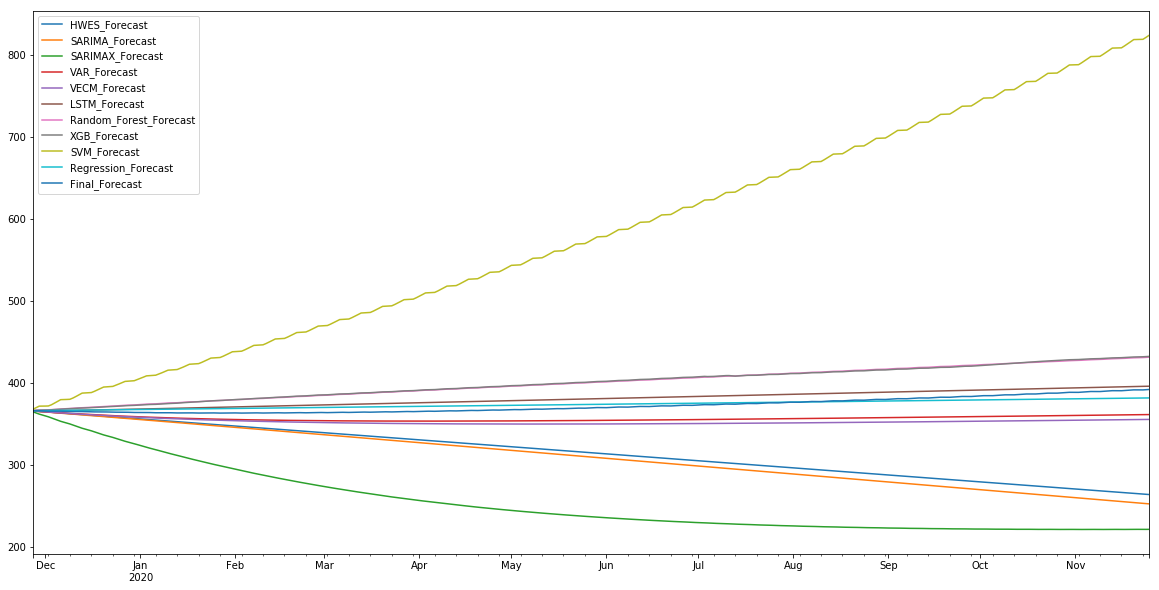

In [179]:
Final_Forecast.plot()